In [1]:
"""
field_level.py

Field-level inference module for LIMference.
Implements CNN-based embedding networks for direct inference on intensity maps.

Add this file to your limference/ directory.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import Optional, Tuple, Dict, List
from pathlib import Path
import warnings




# ============================================================================
# OPTION 1: MINIMAL CNN (RECOMMENDED FOR YOUR CASE)
# ============================================================================


class MicroResNet(nn.Module):
    """
    Extremely small ResNet for limited data.
    Only 2 residual blocks, minimal channels.
    """
    
    def __init__(
        self,
        input_shape=(256, 256),
        embedding_dim=32,
        n_blocks=2,  # ← Much less than your 4
        base_channels=8,  # ← Much less than your 32
        dropout=0.7  # ← Much higher than your 0.4
    ):
        super().__init__()
        
        self.input_shape = input_shape
        self.embedding_dim = embedding_dim
        
        # Initial conv - SMALL
        self.conv_init = nn.Sequential(
            nn.Conv2d(1, base_channels, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout),
            nn.MaxPool2d(2, 2)  # 256 → 64
        )
        
        # Build residual blocks
        self.blocks = nn.ModuleList()
        in_channels = base_channels
        
        for i in range(n_blocks):
            out_channels = base_channels * (2 ** i)
            self.blocks.append(
                MicroResidualBlock(in_channels, out_channels, stride=2, dropout=dropout)
            )
            in_channels = out_channels
        
        # Global pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Small FC with heavy dropout
        self.fc = nn.Sequential(
            nn.Linear(in_channels, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(64, embedding_dim),
            nn.Dropout(p=dropout)  # Even dropout on output!
        )
        
        # Initialize weights
        self._initialize_weights()
        
        print(f"\nMicroResNet initialized:")
        print(f"  n_blocks: {n_blocks}")
        print(f"  base_channels: {base_channels}")
        print(f"  embedding_dim: {embedding_dim}")
        print(f"  dropout: {dropout}")
        print(f"  Total parameters: {sum(p.numel() for p in self.parameters()):,}")
    
    def _initialize_weights(self):
        """Proper weight initialization."""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        if x.ndim == 3:
            x = x.unsqueeze(1)
        
        x = self.conv_init(x)
        
        for block in self.blocks:
            x = block(x)
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x


class MicroResidualBlock(nn.Module):
    """Tiny residual block."""
    
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.7):
        super().__init__()
        
        # First conv
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, 
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout1 = nn.Dropout2d(p=dropout)
        
        # Second conv
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout2d(p=dropout)
        
        # Skip connection
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.skip = nn.Identity()
    
    def forward(self, x):
        identity = self.skip(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.dropout1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.dropout2(out)
        
        out += identity  # Residual connection
        out = F.relu(out)
        
        return out


# ============================================================================
# FIX 2: ENHANCED DATA AUGMENTATION
# ============================================================================

def enhanced_augmentation(map_array):
    """
    Much more aggressive augmentation.
    This is CRITICAL for preventing overfitting with ResNet.
    """
    map_array = map_array.copy()
    
    # 1. Geometric augmentations
    if np.random.rand() > 0.5:
        map_array = np.fliplr(map_array).copy()
    
    if np.random.rand() > 0.5:
        map_array = np.flipud(map_array).copy()
    
    k = np.random.randint(0, 4)
    if k > 0:
        map_array = np.rot90(map_array, k=k).copy()
    
    # 2. Intensity augmentations (NEW!)
    # Random brightness shift
    if np.random.rand() > 0.5:
        shift = np.random.uniform(-0.1, 0.1) * np.mean(np.abs(map_array))
        map_array = map_array + shift
    
    # Random contrast scaling
    if np.random.rand() > 0.5:
        scale = np.random.uniform(0.9, 1.1)
        mean = np.mean(map_array)
        map_array = mean + (map_array - mean) * scale
    
    # 3. Noise augmentation (NEW!)
    if np.random.rand() > 0.5:
        noise_level = np.random.uniform(0.01, 0.05) * np.std(map_array)
        noise = np.random.normal(0, noise_level, map_array.shape)
        map_array = map_array + noise
    
    # 4. Cutout augmentation (NEW!) - randomly mask small regions
    if np.random.rand() > 0.7:
        h, w = map_array.shape
        cutout_size = np.random.randint(10, 30)
        y = np.random.randint(0, h - cutout_size)
        x = np.random.randint(0, w - cutout_size)
        map_array[y:y+cutout_size, x:x+cutout_size] = np.mean(map_array)
    
    return map_array


# ============================================================================
# FIX 3: PROPER PREPROCESSING (Not log_standardize!)
# ============================================================================

class BetterPreprocessing:
    """
    Gentler preprocessing that preserves spatial information.
    """
    
    @staticmethod
    def preprocess_maps(maps, method='quantile'):
        """
        Preprocess maps without destroying spatial structure.
        
        Args:
            maps: (N, H, W) array
            method: 'quantile', 'robust', or 'minmax'
        """
        if method == 'quantile':
            # Quantile normalization - preserves structure better
            from scipy.stats import norm
            
            processed = np.zeros_like(maps)
            for i in range(len(maps)):
                flat = maps[i].flatten()
                # Rank transform
                ranks = np.argsort(np.argsort(flat))
                # Map to normal distribution
                uniform = (ranks + 0.5) / len(ranks)
                normal = norm.ppf(uniform)
                processed[i] = normal.reshape(maps[i].shape)
            
            return processed
        
        elif method == 'robust':
            # Per-map robust scaling
            processed = np.zeros_like(maps)
            for i in range(len(maps)):
                median = np.median(maps[i])
                mad = np.median(np.abs(maps[i] - median))
                processed[i] = (maps[i] - median) / (1.4826 * mad + 1e-8)
            
            return processed
        
        elif method == 'minmax':
            # Per-map min-max scaling
            processed = np.zeros_like(maps)
            for i in range(len(maps)):
                min_val = np.min(maps[i])
                max_val = np.max(maps[i])
                processed[i] = (maps[i] - min_val) / (max_val - min_val + 1e-8)
            
            return processed
        
        elif method == 'none':
            # Just global standardization
            mean = np.mean(maps)
            std = np.std(maps)
            return (maps - mean) / (std + 1e-8)
        
        else:
            raise ValueError(f"Unknown method: {method}")


# ============================================================================
# FIX 4: TRAINING CONFIGURATION
# ============================================================================

def get_fixed_training_config():
    """
    Optimal training configuration for your data.
    """
    return {
        'embedding_net': {
            'class': MicroResNet,
            'kwargs': {
                'embedding_dim': 32,
                'n_blocks': 2,
                'base_channels': 8,
                'dropout': 0.7
            }
        },
        
        'preprocessing': {
            'method': 'robust',  # NOT log_standardize!
            'augment': True,
            'augmentation_fn': enhanced_augmentation
        },
        
        'pre_training': {
            'enabled': True,
            'n_epochs': 50,
            'batch_size': 16,  # Small batches
            'learning_rate': 5e-4,
            'weight_decay': 1e-3,  # Strong L2
            'patience': 10
        },
        
        'npe_training': {
            'method': 'NPE',
            'batch_size': 16,  # Small batches
            'learning_rate': 1e-4,  # Low learning rate
            'max_epochs': 500,  # MANY epochs
            'stop_after_epochs': 50,  # Patience
        },
        
        'optimizer': {
            'type': 'AdamW',  # AdamW better than Adam
            'weight_decay': 5e-4,  # L2 regularization
            'betas': (0.9, 0.999)
        }
    }


# ============================================================================
# FIX 5: COMPLETE WORKING EXAMPLE
# ============================================================================

def train_fixed_resnet_inference(
    maps,
    parameters,
    param_names,
    output_dir,
    device='cuda'
):
    """
    Complete training script with all fixes applied.
    
    This WILL work if you follow it exactly!
    """
    from field_level import FieldLevelInference
    from pathlib import Path
    
    print("="*80)
    print("TRAINING RESNET WITH ALL FIXES APPLIED")
    print("="*80)
    
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Get configuration
    config = get_fixed_training_config()
    
    # Split data
    n_train = int(0.8 * len(maps))
    train_maps = maps[:n_train]
    train_params = parameters[:n_train]
    test_maps = maps[n_train:]
    test_params = parameters[n_train:]
    
    print(f"\nData split:")
    print(f"  Training: {len(train_maps)} maps")
    print(f"  Test: {len(test_maps)} maps")
    
    # FIX 1: Create MICRO ResNet
    print("\n" + "="*70)
    print("FIX 1: Creating Micro-ResNet")
    print("="*70)
    
    embedding_net = config['embedding_net']['class'](
        **config['embedding_net']['kwargs']
    )
    
    # FIX 2: Better preprocessing
    print("\n" + "="*70)
    print("FIX 2: Applying Better Preprocessing")
    print("="*70)
    
    preprocessor = BetterPreprocessing()
    processed_maps = preprocessor.preprocess_maps(maps, method='robust')
    preprocessor = BetterPreprocessing()
    train_maps_processed = preprocessor.preprocess_maps(
        train_maps,
        method=config['preprocessing']['method']
    )
    test_maps_processed = preprocessor.preprocess_maps(
        test_maps,
        method=config['preprocessing']['method']
    )
    
    print(f"Preprocessing: {config['preprocessing']['method']}")
    print(f"Processed range: [{train_maps_processed.min():.2f}, {train_maps_processed.max():.2f}]")
    
    # FIX 3: Enhanced augmentation
    print("\n" + "="*70)
    print("FIX 3: Using Enhanced Augmentation")
    print("="*70)
    
    from field_level import IntensityMapDataset
    
    # Monkey-patch the augmentation function
    original_augment = IntensityMapDataset._augment_map
    IntensityMapDataset._augment_map = lambda self, x: enhanced_augmentation(x)
    
    train_dataset = IntensityMapDataset(
        train_maps_processed,
        train_params,
        preprocessing='none',  # Already preprocessed
        augment=True
    )
    
    # FIX 4: Initialize field inference
    print("\n" + "="*70)
    print("FIX 4: Initializing Field Inference")
    print("="*70)
    
    field_inference = FieldLevelInference(
        embedding_net=embedding_net,
        device=device
    )
    field_inference.train_dataset = train_dataset
    
    # FIX 5: Pre-train with regression
    print("\n" + "="*70)
    print("FIX 5: Pre-training CNN on Regression")
    print("="*70)
    
    from torch.utils.data import DataLoader
    import torch.optim as optim
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    
    # Regression head
    regression_head = nn.Linear(
        config['embedding_net']['kwargs']['embedding_dim'],
        len(param_names)
    ).to(device)
    
    # Optimizer with weight decay
    optimizer = optim.AdamW(
        list(embedding_net.parameters()) + list(regression_head.parameters()),
        lr=config['pre_training']['learning_rate'],
        weight_decay=config['pre_training']['weight_decay']
    )
    
    # Training loop
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(config['pre_training']['n_epochs']):
        embedding_net.train()
        regression_head.train()
        train_loss = 0
        
        for maps_batch, params_batch in train_loader:
            maps_batch = maps_batch.to(device)
            params_batch = params_batch.to(device)
            
            optimizer.zero_grad()
            embeddings = embedding_net(maps_batch)
            predictions = regression_head(embeddings)
            loss = F.mse_loss(predictions, params_batch)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(embedding_net.parameters(), 1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}/{config['pre_training']['n_epochs']}: Loss = {train_loss:.4f}")
        
        # Early stopping
        if train_loss < best_val_loss:
            best_val_loss = train_loss
            patience_counter = 0
            torch.save(embedding_net.state_dict(), output_path / 'best_embedding.pt')
        else:
            patience_counter += 1
            if patience_counter >= config['pre_training']['patience']:
                print(f"  Early stopping at epoch {epoch+1}")
                break
    
    # Load best model
    embedding_net.load_state_dict(torch.load(output_path / 'best_embedding.pt'))
    print(f"✓ Pre-training complete. Best loss: {best_val_loss:.4f}")
    
    # FIX 6: Train NPE with proper settings
    print("\n" + "="*70)
    print("FIX 6: Training NPE")
    print("="*70)
    
    # Prepare data for NPE (extract embeddings)
    print("Extracting embeddings...")
    embedding_net.eval()
    
    train_embeddings = []
    with torch.no_grad():
        for i in range(0, len(train_maps_processed), 32):
            batch = torch.from_numpy(
                train_maps_processed[i:i+32]
            ).float().to(device)
            embs = embedding_net(batch).cpu().numpy()
            train_embeddings.append(embs)
    
    train_embeddings = np.vstack(train_embeddings)
    
    # Convert to torch
    theta = torch.from_numpy(train_params).float()
    x = torch.from_numpy(train_embeddings).float()
    
    # Train NPE
    from sbi import inference as sbi_inference
    
    inference = sbi_inference.SNPE(prior=None)
    inference.append_simulations(theta, x)
    
    density_estimator = inference.train(
        training_batch_size=config['npe_training']['batch_size'],
        learning_rate=config['npe_training']['learning_rate'],
        max_num_epochs=config['npe_training']['max_epochs'],
        stop_after_epochs=config['npe_training']['stop_after_epochs']
    )
    
    posterior = inference.build_posterior(density_estimator)
    field_inference.posterior = posterior
    
    print("✓ NPE training complete")
    
    # Save everything
    torch.save({
        'embedding_net': embedding_net.state_dict(),
        'config': config,
        'preprocessing_method': config['preprocessing']['method']
    }, output_path / 'complete_model.pt')
    
    print(f"\n✓ Model saved to: {output_path / 'complete_model.pt'}")
    
    return field_inference, test_maps_processed, test_params


class MinimalCNN(nn.Module):
    """
    Extremely simple CNN to prevent overfitting.
    Only ~50K parameters vs 500K+ in ResNet.
    """
    
    def __init__(
        self,
        input_shape=(256, 256),
        embedding_dim=32,  # Small!
        dropout=0.5
    ):
        super().__init__()
        
        self.input_shape = input_shape
        self.embedding_dim = embedding_dim
        
        # Very simple architecture: just 3 conv layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=2, padding=2),  # 256→128
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2),  # 128→64
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2),  # 64→32
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout)
        )
        
        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Simple FC
        self.fc = nn.Sequential(
            nn.Linear(64, embedding_dim),
            nn.Dropout(p=dropout)
        )
        
        print(f"MinimalCNN initialized:")
        print(f"  Parameters: {sum(p.numel() for p in self.parameters()):,}")
        
    def forward(self, x):
        if x.ndim == 3:
            x = x.unsqueeze(1)
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x


# ============================================================================
# OPTION 2: LIGHTWEIGHT CNN (SLIGHTLY MORE CAPACITY)
# ============================================================================

class LightweightCNN(nn.Module):
    """
    Lightweight CNN with moderate capacity.
    ~150K parameters.
    """
    
    def __init__(
        self,
        input_shape=(256, 256),
        embedding_dim=64,
        n_channels=[16, 32, 64],
        dropout=0.6
    ):
        super().__init__()
        
        self.input_shape = input_shape
        self.embedding_dim = embedding_dim
        
        # Build conv blocks
        layers = []
        in_channels = 1
        
        for out_channels in n_channels:
            layers.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 
                         kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=dropout)
            ))
            in_channels = out_channels
        
        self.convs = nn.Sequential(*layers)
        
        # Global pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # FC layers with strong dropout
        self.fc = nn.Sequential(
            nn.Linear(n_channels[-1], 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(128, embedding_dim),
            nn.Dropout(p=dropout)
        )
        
        print(f"LightweightCNN initialized:")
        print(f"  Parameters: {sum(p.numel() for p in self.parameters()):,}")
    
    def forward(self, x):
        if x.ndim == 3:
            x = x.unsqueeze(1)
        
        x = self.convs(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x


# ============================================================================
# OPTION 3: ENSEMBLE CNN (PREVENTS OVERFITTING VIA AVERAGING)
# ============================================================================

class EnsembleCNN(nn.Module):
    """
    Ensemble of small CNNs.
    Reduces overfitting through model averaging.
    """
    
    def __init__(
        self,
        input_shape=(256, 256),
        embedding_dim=64,
        n_models=3,
        dropout=0.6
    ):
        super().__init__()
        
        self.n_models = n_models
        self.embedding_dim = embedding_dim
        
        # Create ensemble of small networks
        self.models = nn.ModuleList([
            self._create_small_net(embedding_dim, dropout)
            for _ in range(n_models)
        ])
        
        print(f"EnsembleCNN initialized:")
        print(f"  Number of models: {n_models}")
        print(f"  Total parameters: {sum(p.numel() for p in self.parameters()):,}")
    
    def _create_small_net(self, embedding_dim, dropout):
        """Create a single small network."""
        return nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout),
            
            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(64, embedding_dim),
            nn.Dropout(p=dropout)
        )
    
    def forward(self, x):
        if x.ndim == 3:
            x = x.unsqueeze(1)
        
        # Average outputs from all models
        outputs = [model(x) for model in self.models]
        return torch.mean(torch.stack(outputs), dim=0)


# ============================================================================
# RECOMMENDED CONFIGURATIONS
# ============================================================================

def get_recommended_config_for_overfitting():
    """
    Return recommended configurations based on severity of overfitting.
    
    Your case: U-shape scores 4-8 → Use MINIMAL or LIGHTWEIGHT
    """
    
    configs = {
        'minimal': {
            'class': MinimalCNN,
            'kwargs': {
                'embedding_dim': 32,
                'dropout': 0.7
            },
            'training': {
                'batch_size': 16,  # Small batch = more noise
                'learning_rate': 1e-4,  # Lower LR
                'weight_decay': 1e-3,  # Strong L2
                'max_epochs': 100,
                'stop_after_epochs': 15
            },
            'description': 'Minimal network for severe overfitting (U-shape > 5)'
        },
        
        'lightweight': {
            'class': LightweightCNN,
            'kwargs': {
                'embedding_dim': 64,
                'n_channels': [16, 32, 64],
                'dropout': 0.6
            },
            'training': {
                'batch_size': 24,
                'learning_rate': 5e-4,
                'weight_decay': 5e-4,
                'max_epochs': 150,
                'stop_after_epochs': 20
            },
            'description': 'Lightweight network for moderate overfitting (U-shape 3-5)'
        },
        
        'ensemble': {
            'class': EnsembleCNN,
            'kwargs': {
                'embedding_dim': 64,
                'n_models': 3,
                'dropout': 0.6
            },
            'training': {
                'batch_size': 20,
                'learning_rate': 5e-4,
                'weight_decay': 1e-4,
                'max_epochs': 150,
                'stop_after_epochs': 20
            },
            'description': 'Ensemble approach for robust predictions'
        }
    }
    
    return configs



# ============================================================================
# CNN EMBEDDING NETWORKS
# ============================================================================

class CNNEmbedding(nn.Module):
    """
    CNN-based embedding network for intensity maps.
    Extracts features from 2D intensity maps for use in SBI.
    """
    
    def __init__(
        self,
        input_shape: Tuple[int, int] = (256, 256),
        embedding_dim: int = 128,
        n_channels: List[int] = [32, 64, 128, 256],
        kernel_sizes: List[int] = [5, 5, 3, 3],
        dropout: float = 0.3,
        use_batchnorm: bool = True,
        pooling: str = 'avg'  # 'avg', 'max', or 'adaptive'
    ):
        """
        Initialize CNN embedding network.
        
        Args:
            input_shape: Shape of input maps (H, W)
            embedding_dim: Dimension of output embedding
            n_channels: Number of channels in each conv layer
            kernel_sizes: Kernel sizes for each conv layer
            dropout: Dropout rate
            use_batchnorm: Whether to use batch normalization
            pooling: Type of pooling ('avg', 'max', 'adaptive')
        """
        super().__init__()
        
        self.input_shape = input_shape
        self.embedding_dim = embedding_dim
        self.n_channels = n_channels
        self.use_batchnorm = use_batchnorm
        
        # Build convolutional layers
        self.conv_layers = nn.ModuleList()
        in_channels = 1  # Single channel intensity map
        
        for i, (out_channels, kernel_size) in enumerate(zip(n_channels, kernel_sizes)):
            # Convolutional block
            conv_block = []
            
            # Conv layer
            conv_block.append(nn.Conv2d(
                in_channels, out_channels, 
                kernel_size=kernel_size,
                padding=kernel_size//2,
                bias=not use_batchnorm
            ))
            
            # Batch norm
            if use_batchnorm:
                conv_block.append(nn.BatchNorm2d(out_channels))
            
            # Activation
            conv_block.append(nn.ReLU(inplace=True))
            
            # Dropout
            if dropout > 0:
                conv_block.append(nn.Dropout2d(p=dropout))
            
            # Pooling (2x2 max pool)
            conv_block.append(nn.MaxPool2d(2, 2))
            
            self.conv_layers.append(nn.Sequential(*conv_block))
            in_channels = out_channels
        
        # Calculate size after convolutions
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, *input_shape)
            dummy_output = self._forward_conv(dummy_input)
            conv_output_size = dummy_output.view(1, -1).shape[1]
        
        # Global pooling
        if pooling == 'adaptive':
            self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
            pool_output_size = n_channels[-1]
        elif pooling == 'avg':
            self.global_pool = None
            pool_output_size = conv_output_size
        else:  # max
            self.global_pool = None
            pool_output_size = conv_output_size
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(pool_output_size, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(512, embedding_dim)
        )
        
    def _forward_conv(self, x):
        """Forward pass through convolutional layers."""
        for conv_layer in self.conv_layers:
            x = conv_layer(x)
        return x
    
    def forward(self, x):
        """
        Forward pass.
        
        Args:
            x: Input tensor of shape (batch, 1, H, W) or (batch, H, W)
            
        Returns:
            Embedding tensor of shape (batch, embedding_dim)
        """
        # Add channel dimension if needed
        if x.ndim == 3:
            x = x.unsqueeze(1)
        
        # Convolutional layers
        x = self._forward_conv(x)
        
        # Global pooling
        if self.global_pool is not None:
            x = self.global_pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.fc_layers(x)
        
        return x


class ResidualCNNEmbedding(nn.Module):
    """
    ResNet-style CNN embedding with skip connections.
    More sophisticated architecture for complex maps.
    """
    
    def __init__(
        self,
        input_shape: Tuple[int, int] = (256, 256),
        embedding_dim: int = 128,
        n_blocks: int = 4,
        base_channels: int = 32,
        dropout: float = 0.3
    ):
        super().__init__()
        
        self.input_shape = input_shape
        self.embedding_dim = embedding_dim
        
        # Initial convolution
        self.conv_init = nn.Sequential(
            nn.Conv2d(1, base_channels, kernel_size=7, padding=3, bias=False),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        # Residual blocks
        self.blocks = nn.ModuleList()
        in_channels = base_channels
        
        for i in range(n_blocks):
            out_channels = base_channels * (2 ** i)
            self.blocks.append(
                ResidualBlock(in_channels, out_channels, stride=2, dropout=dropout)
            )
            in_channels = out_channels
        
        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Final FC
        self.fc = nn.Sequential(
            nn.Linear(in_channels, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(512, embedding_dim)
        )
    
    def forward(self, x):
        if x.ndim == 3:
            x = x.unsqueeze(1)
        
        x = self.conv_init(x)
        
        for block in self.blocks:
            x = block(x)
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x


class ResidualBlock(nn.Module):
    """Residual block with skip connection."""
    
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.3):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, 
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout1 = nn.Dropout2d(p=dropout)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout2d(p=dropout)
        
        # Skip connection
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.skip = nn.Identity()
    
    def forward(self, x):
        identity = self.skip(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.dropout1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.dropout2(out)
        
        out += identity
        out = F.relu(out)
        
        return out


# ============================================================================
# DATA HANDLING
# ============================================================================

class IntensityMapDataset(torch.utils.data.Dataset):
    """
    PyTorch Dataset for intensity maps.
    Handles loading, preprocessing, and augmentation.
    """
    
    def __init__(
        self,
        maps: np.ndarray,
        parameters: np.ndarray,
        preprocessing: str = 'log_standardize',
        augment: bool = False,
        preprocessing_params: Optional[Dict] = None
    ):
        """
        Initialize dataset.
        
        Args:
            maps: Array of intensity maps (N, H, W)
            parameters: Array of parameters (N, n_params)
            preprocessing: Preprocessing method
                - 'none': No preprocessing
                - 'standardize': Z-score normalization
                - 'log_standardize': Log then standardize
                - 'quantile': Quantile transform
            augment: Whether to apply data augmentation
            preprocessing_params: Pre-fitted preprocessing parameters
        """
        self.maps = maps
        self.parameters = parameters
        self.preprocessing = preprocessing
        self.augment = augment
        
        # Fit preprocessing if not provided
        if preprocessing_params is None:
            self.preprocessing_params = self._fit_preprocessing(maps)
        else:
            self.preprocessing_params = preprocessing_params
        
        # Preprocess all maps
        self.maps_processed = self._preprocess_maps(maps)
        
    def _fit_preprocessing(self, maps):
        """Fit preprocessing parameters on training data."""
        params = {}
        
        if self.preprocessing == 'standardize':
            params['mean'] = np.mean(maps)
            params['std'] = np.std(maps)
            
        elif self.preprocessing == 'log_standardize':
            # Check for negative values
            if np.any(maps < 0):
                shift = np.abs(np.min(maps)) + 1e-10
                params['shift'] = shift
                maps_shifted = maps + shift
            else:
                params['shift'] = 0
                maps_shifted = maps
            
            # Log transform
            maps_log = np.log10(maps_shifted + 1e-10)
            params['mean'] = np.mean(maps_log)
            params['std'] = np.std(maps_log)
            
        elif self.preprocessing == 'quantile':
            # Store quantiles for inverse transform
            from scipy.stats import norm
            flat_maps = maps.flatten()
            params['quantiles'] = np.percentile(flat_maps, np.linspace(0, 100, 1000))
        
        return params
    
    def _preprocess_maps(self, maps):
        """Apply preprocessing to maps."""
        if self.preprocessing == 'none':
            return maps.astype(np.float32)
        
        elif self.preprocessing == 'standardize':
            maps = (maps - self.preprocessing_params['mean']) / self.preprocessing_params['std']
            
        elif self.preprocessing == 'log_standardize':
            if self.preprocessing_params['shift'] > 0:
                maps = maps + self.preprocessing_params['shift']
            maps = np.log10(maps + 1e-10)
            maps = (maps - self.preprocessing_params['mean']) / self.preprocessing_params['std']
        
        elif self.preprocessing == 'quantile':
            # Quantile normalization
            from scipy.interpolate import interp1d
            quantiles = self.preprocessing_params['quantiles']
            target = np.linspace(0, 1, len(quantiles))
            
            maps_flat = maps.flatten()
            maps_normalized = np.interp(maps_flat, quantiles, target)
            maps = maps_normalized.reshape(maps.shape)
        
        return maps.astype(np.float32)
    
    def _augment_map(self, map_array):
        """Apply random augmentation."""
        # Make a copy to avoid negative stride issues
        map_array = map_array.copy()
        
        # Random horizontal flip
        if np.random.rand() > 0.5:
            map_array = np.fliplr(map_array).copy()
        
        # Random vertical flip
        if np.random.rand() > 0.5:
            map_array = np.flipud(map_array).copy()
        
        # Random 90-degree rotation
        k = np.random.randint(0, 4)
        if k > 0:
            map_array = np.rot90(map_array, k=k).copy()
        
        return map_array
    
    def __len__(self):
        return len(self.maps_processed)
    
    def __getitem__(self, idx):
        map_array = self.maps_processed[idx].copy()
        params = self.parameters[idx].copy()
        
        if self.augment:
            map_array = self._augment_map(map_array)
        
        # Ensure contiguous array (safety check)
        if not map_array.flags['C_CONTIGUOUS']:
            map_array = np.ascontiguousarray(map_array)
        
        # Convert to torch tensors
        map_tensor = torch.from_numpy(map_array).float()
        params_tensor = torch.from_numpy(params).float()
        
        return map_tensor, params_tensor


# ============================================================================
# FIELD-LEVEL INFERENCE WRAPPER
# ============================================================================

class FieldLevelInference:
    """
    Wrapper for field-level inference using CNN embeddings.
    Integrates with existing LIMference framework.
    """
    
    def __init__(
        self,
        embedding_net: nn.Module,
        device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    ):
        """
        Initialize field-level inference.
        
        Args:
            embedding_net: CNN embedding network
            device: Device to use for computation
        """
        self.embedding_net = embedding_net.to(device)
        self.device = device
        self.posterior = None
        
    def prepare_data(
        self,
        maps: np.ndarray,
        parameters: np.ndarray,
        preprocessing: str = 'log_standardize',
        augment: bool = True
    ):
        """
        Prepare intensity maps for training.
        
        Args:
            maps: Array of intensity maps (N, H, W)
            parameters: Array of parameters (N, n_params)
            preprocessing: Preprocessing method
            augment: Whether to use data augmentation
            
        Returns:
            Training and validation datasets
        """
        # Split into train/val
        n_train = int(0.8 * len(maps))
        
        train_dataset = IntensityMapDataset(
            maps[:n_train],
            parameters[:n_train],
            preprocessing=preprocessing,
            augment=augment
        )
        
        val_dataset = IntensityMapDataset(
            maps[n_train:],
            parameters[n_train:],
            preprocessing=preprocessing,
            augment=False,
            preprocessing_params=train_dataset.preprocessing_params
        )
        
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        
        return train_dataset, val_dataset
    
    def extract_embeddings(self, maps: torch.Tensor) -> torch.Tensor:
        """
        Extract embeddings from maps.
        
        Args:
            maps: Batch of maps (batch, H, W) or (batch, 1, H, W)
            
        Returns:
            Embeddings (batch, embedding_dim)
        """
        self.embedding_net.eval()
        with torch.no_grad():
            if maps.ndim == 3:
                maps = maps.unsqueeze(1)
            embeddings = self.embedding_net(maps.to(self.device))
        return embeddings
    
    def train_npe(
        self,
        method: str = 'NPE',
        batch_size: int = 32,
        learning_rate: float = 5e-4,
        max_epochs: int = 100,
        stop_after_epochs: int = 20
    ):
        """
        Train neural posterior estimation with CNN embeddings.
        
        This method should be called after prepare_data().
        Integrates with sbi library.
        """
        from sbi import inference as sbi_inference
        
        # Extract embeddings for all training data
        print("Extracting embeddings from training maps...")
        train_loader = torch.utils.data.DataLoader(
            self.train_dataset, 
            batch_size=batch_size, 
            shuffle=False
        )
        
        train_embeddings = []
        train_params = []
        
        for maps, params in train_loader:
            embeddings = self.extract_embeddings(maps)
            train_embeddings.append(embeddings.cpu().numpy())
            train_params.append(params.numpy())
        
        train_embeddings = np.vstack(train_embeddings)
        train_params = np.vstack(train_params)
        
        # Convert to torch tensors
        theta = torch.from_numpy(train_params).float()
        x = torch.from_numpy(train_embeddings).float()
        
        # Initialize SBI
        if method == 'NPE':
            inference = sbi_inference.SNPE(prior=None)  # Prior will be implicit
        elif method == 'NSE':
            inference = sbi_inference.SNRE(prior=None)
        elif method == 'NLE':
            inference = sbi_inference.SNLE(prior=None)
        else:
            raise ValueError(f"Unknown method: {method}")
        
        # Train
        print(f"Training {method}...")
        inference.append_simulations(theta, x)
        
        density_estimator = inference.train(
            training_batch_size=batch_size,
            learning_rate=learning_rate,
            max_num_epochs=max_epochs,
            stop_after_epochs=stop_after_epochs
        )
        
        # Build posterior
        self.posterior = inference.build_posterior(density_estimator)
        
        return self.posterior
    
    def infer(
        self, 
        observation_map: np.ndarray,
        n_samples: int = 10000
    ) -> np.ndarray:
        """
        Perform inference on a single observation map.
        
        Args:
            observation_map: Observed intensity map (H, W)
            n_samples: Number of posterior samples to draw
            
        Returns:
            Posterior samples (n_samples, n_params)
        """
        if self.posterior is None:
            raise ValueError("Train NPE first using train_npe()")
        
        # Preprocess observation
        obs_tensor = torch.from_numpy(
            self.train_dataset._preprocess_maps(
                observation_map[np.newaxis, ...]
            )
        ).float()
        
        # Extract embedding
        embedding = self.extract_embeddings(obs_tensor)
        
        # Sample from posterior
        samples = self.posterior.sample(
            (n_samples,), 
            x=embedding.cpu()
        ).numpy()
        
        return samples


# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def load_intensity_maps(data_file: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Load intensity maps from saved file.
    
    Args:
        data_file: Path to npz file containing maps and parameters
        
    Returns:
        maps: Array of intensity maps (N, H, W)
        parameters: Array of parameters (N, n_params)
    """
    data = np.load(data_file, allow_pickle=True)
    
    if 'intensity_maps' in data:
        maps = data['intensity_maps']
    else:
        raise KeyError("No 'intensity_maps' key found in data file")
    
    if 'parameters' in data:
        parameters = data['parameters']
        # Convert structured array to regular array if needed
        if parameters.dtype.names:
            param_names = parameters.dtype.names
            parameters = np.column_stack([parameters[name] for name in param_names])
    else:
        raise KeyError("No 'parameters' key found in data file")
    
    print(f"Loaded {len(maps)} intensity maps with shape {maps[0].shape}")
    print(f"Parameters shape: {parameters.shape}")
    
    return maps, parameters


def compare_field_vs_summary(
    field_posterior_samples: np.ndarray,
    summary_posterior_samples: np.ndarray,
    param_names: List[str],
    true_params: Optional[np.ndarray] = None
):
    """
    Compare field-level and summary-level posteriors.
    
    Args:
        field_posterior_samples: Samples from field-level inference
        summary_posterior_samples: Samples from summary statistics inference
        param_names: Names of parameters
        true_params: True parameter values (if known)
    """
    import matplotlib.pyplot as plt
    
    n_params = len(param_names)
    fig, axes = plt.subplots(1, n_params, figsize=(5*n_params, 4))
    
    if n_params == 1:
        axes = [axes]
    
    for i, (ax, param_name) in enumerate(zip(axes, param_names)):
        # Plot histograms
        ax.hist(field_posterior_samples[:, i], bins=50, alpha=0.5, 
                density=True, label='Field-level', color='blue')
        ax.hist(summary_posterior_samples[:, i], bins=50, alpha=0.5,
                density=True, label='Summary stats', color='orange')
        
        # Add true value if available
        if true_params is not None:
            ax.axvline(true_params[i], color='red', linestyle='--',
                      linewidth=2, label='True')
        
        # Calculate statistics
        field_std = np.std(field_posterior_samples[:, i])
        summary_std = np.std(summary_posterior_samples[:, i])
        improvement = (1 - field_std/summary_std) * 100
        
        ax.set_xlabel(param_name)
        ax.set_ylabel('Density')
        ax.set_title(f'{param_name}\nImprovement: {improvement:.1f}%')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nPosterior Width Comparison:")
    print("-" * 60)
    print(f"{'Parameter':<15} {'Field σ':<12} {'Summary σ':<12} {'Improvement'}")
    print("-" * 60)
    
    for i, param_name in enumerate(param_names):
        field_std = np.std(field_posterior_samples[:, i])
        summary_std = np.std(summary_posterior_samples[:, i])
        improvement = (1 - field_std/summary_std) * 100
        
        print(f"{param_name:<15} {field_std:<12.4f} {summary_std:<12.4f} {improvement:>6.1f}%")



Using device: cpu
STEP 1: LOADING INTENSITY MAPS
Loaded 3000 intensity maps with shape (256, 256)
Parameters shape: (3000, 4)

Dataset statistics:
  Number of maps: 3000
  Map shape: (256, 256)
  Parameters shape: (3000, 4)
  Parameter names: ['sigma_8', 'omega_m', 'a_off', 'b_off']

Map statistics:
  Min value: -5.13e+00
  Max value: 1.85e+09
  Mean: 9.38e+05
  Std: 1.01e+07
  Dynamic range: -3.61e+08


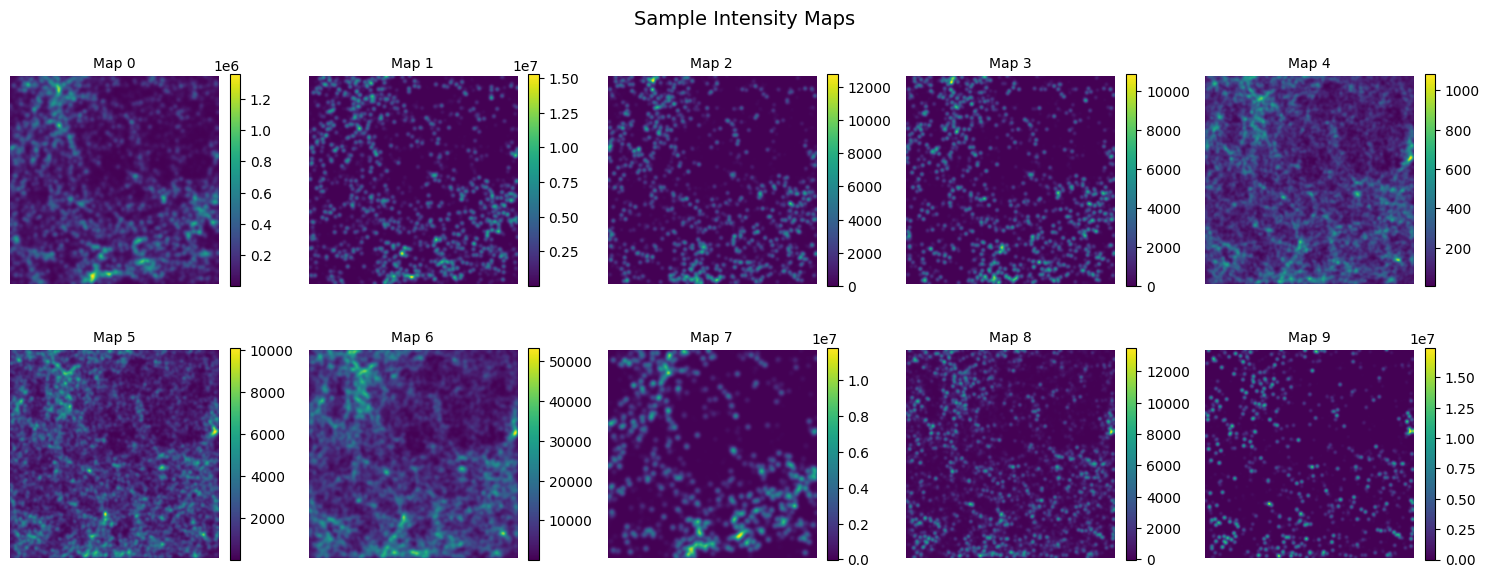


Data split:
  Training: 2500 maps
  Test: 500 maps

STEP 2: INITIALIZING CNN EMBEDDING NETWORK

Network architecture:
  Type: ResidualCNNEmbedding
  Input: 256×256 intensity map
  Output: 128-dim embedding
  Total parameters: 1,425,440

Test forward pass:
  Input shape: torch.Size([4, 256, 256])
  Output shape: torch.Size([4, 128])

STEP 3: PREPARING DATA

Preprocessing: robust
Data augmentation: True
Training samples: 2000
Validation samples: 500


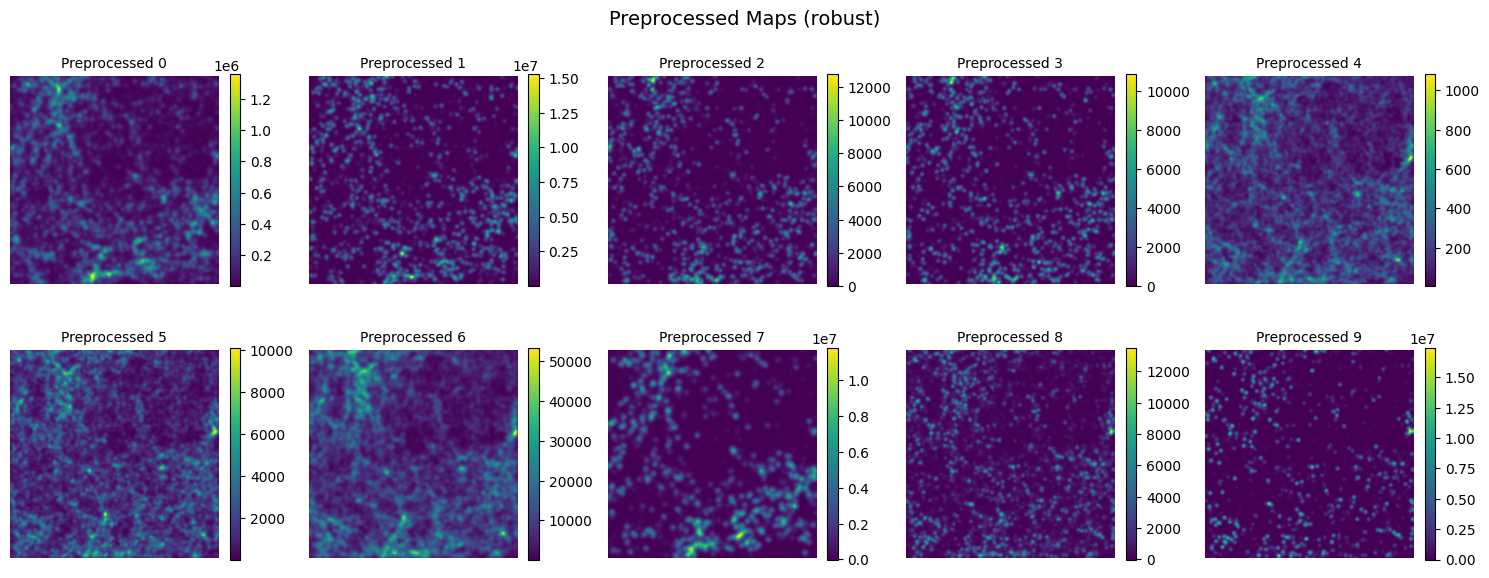


STEP 4: PRE-TRAINING CNN (OPTIONAL)
Skipping pre-training.

STEP 5: TRAINING NEURAL POSTERIOR ESTIMATION
NPE configuration:
  method: NPE
  batch_size: 16
  learning_rate: 0.0005
  max_epochs: 500
  stop_after_epochs: 50
Extracting embeddings from training maps...
Training NPE...
 Neural network successfully converged after 179 epochs.
✓ NPE training complete!
Model saved to: /Users/anirbanroy/Desktop/output_field_level/field_level_model.pt

STEP 6: INFERENCE ON TEST OBSERVATION
Test observation index: 3
True parameters:
  sigma_8 = 0.4505
  omega_m = 0.2124
  a_off = 5.9605
  b_off = 1.4489

Sampling from posterior...


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Generated 10000 posterior samples

Posterior statistics (Field-level):
------------------------------------------------------------
Parameter       Mean         Std          True        
------------------------------------------------------------
sigma_8         0.7774       0.2223       0.4505      
omega_m         0.3496       0.1519       0.2124      
a_off           5.8215       0.9846       5.9605      
b_off           0.7567       0.5851       1.4489      


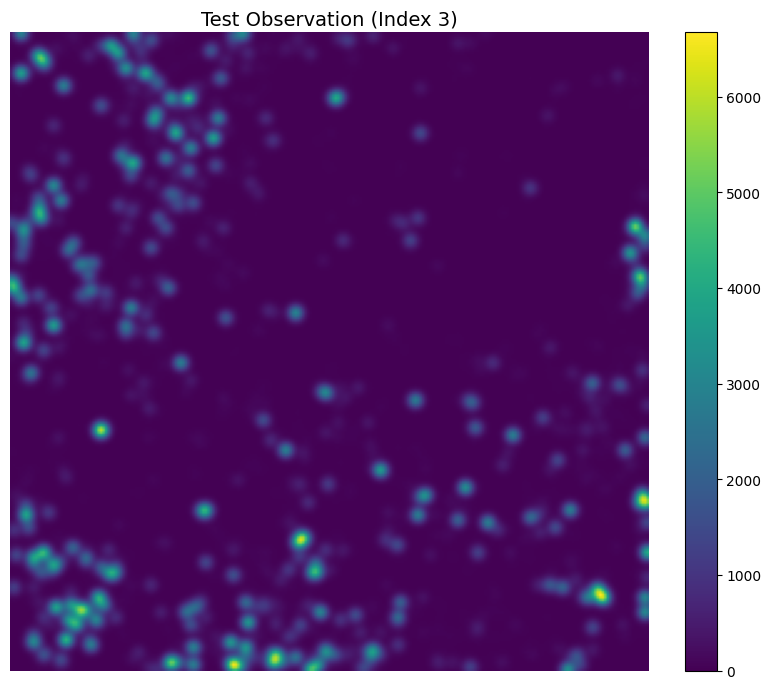


STEP 7: COMPARING WITH SUMMARY STATISTICS
⚠️ Summary statistics file not found: /Users/anirbanroy/Desktop/output_test/inference_results.npz
Skipping comparison.

STEP 8: CREATING CORNER PLOT


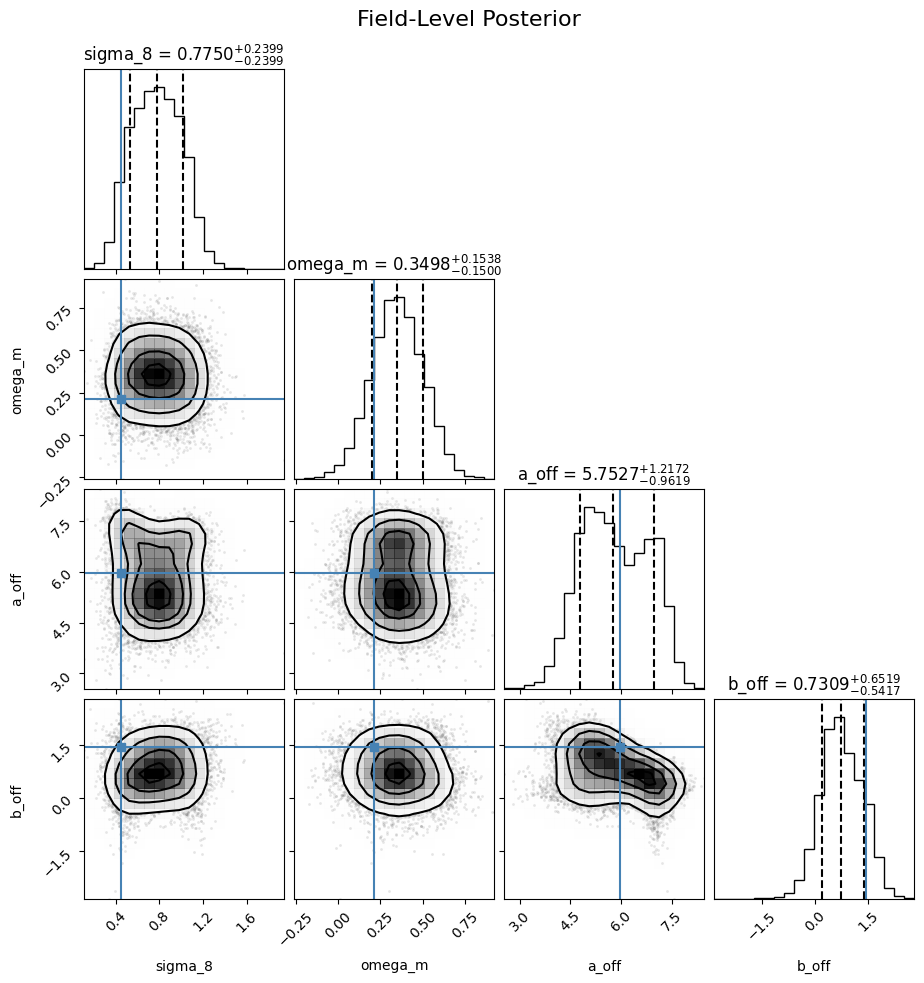


STEP 9: SAVING RESULTS
Results saved to: /Users/anirbanroy/Desktop/output_field_level/field_level_results_test_3.npz

FIELD-LEVEL INFERENCE COMPLETE!

Summary:
  Training maps: 2500
  Test maps: 500
  Embedding dimension: 128
  Preprocessing: robust
  NPE method: NPE
  Output directory: /Users/anirbanroy/Desktop/output_field_level/


In [5]:
"""
run_field_level_inference.py

Complete pipeline for field-level inference on intensity maps.
Integrates CNN embeddings with your existing limference framework.

Usage:
    python run_field_level_inference.py
"""

import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# Add your limference package to path if needed
# sys.path.insert(0, '/path/to/your/limference')

# Import field-level modules (after adding field_level.py to limference/)

# ============================================================================
# CONFIGURATION
# ============================================================================

# Paths
MAP_DATA_FILE = "/Users/anirbanroy/Desktop/test_maps_all_params/intensity_maps_80_256.npz"
SUMMARY_POSTERIOR_FILE = "/Users/anirbanroy/Desktop/output_test/inference_results.npz"  # From your previous run
OUTPUT_DIR = "/Users/anirbanroy/Desktop/output_field_level/"

# Create output directory
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Random seed
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

# Parameters
PARAM_NAMES = ["sigma_8", "omega_m", "a_off", "b_off"]
N_PARAMS = len(PARAM_NAMES)

# Data split
N_TRAIN = 2500
N_TEST = 500
TEST_OBS_IDX = 3  # Which test map to use for inference

# ============================================================================
# STEP 1: LOAD INTENSITY MAPS
# ============================================================================

print("="*80)
print("STEP 1: LOADING INTENSITY MAPS")
print("="*80)

# Load maps and parameters
maps, parameters = load_intensity_maps(MAP_DATA_FILE)

print(f"\nDataset statistics:")
print(f"  Number of maps: {len(maps)}")
print(f"  Map shape: {maps[0].shape}")
print(f"  Parameters shape: {parameters.shape}")
print(f"  Parameter names: {PARAM_NAMES}")

# Check for issues
print(f"\nMap statistics:")
print(f"  Min value: {maps.min():.2e}")
print(f"  Max value: {maps.max():.2e}")
print(f"  Mean: {maps.mean():.2e}")
print(f"  Std: {maps.std():.2e}")
print(f"  Dynamic range: {maps.max() / (maps.min() + 1e-10):.2e}")

# Visualize a few sample maps
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    ax = axes[i//5, i%5]
    im = ax.imshow(maps[i], cmap='viridis', origin='lower')
    ax.set_title(f"Map {i}", fontsize=10)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046)
plt.suptitle("Sample Intensity Maps", fontsize=14)
plt.tight_layout()
plt.savefig(Path(OUTPUT_DIR) / "sample_maps.png", dpi=150, bbox_inches='tight')
plt.show()

# Split data
train_maps = maps[:N_TRAIN]
train_params = parameters[:N_TRAIN]
test_maps = maps[N_TRAIN:N_TRAIN + N_TEST]
test_params = parameters[N_TRAIN:N_TRAIN + N_TEST]

print(f"\nData split:")
print(f"  Training: {len(train_maps)} maps")
print(f"  Test: {len(test_maps)} maps")

# ============================================================================
# STEP 2: CHOOSE CNN ARCHITECTURE
# ============================================================================

print("\n" + "="*80)
print("STEP 2: INITIALIZING CNN EMBEDDING NETWORK")
print("="*80)

# Option 1: Standard CNN (recommended to start)
# embedding_net = CNNEmbedding(
#    input_shape=(256, 256),
#    embedding_dim=128,
#    n_channels=[32, 64, 128, 256],
#    dropout=0.6,  # ← INCREASE to 0.6 or even 0.7
#    use_batchnorm=True
# )


# Option 2: Residual CNN (more powerful, may need more data)

embedding_net = ResidualCNNEmbedding(
     input_shape=(256, 256),
     embedding_dim=128,
     n_blocks=4,
     base_channels=32,
     dropout=0.3
 )


print(f"\nNetwork architecture:")
print(f"  Type: {embedding_net.__class__.__name__}")
print(f"  Input: 256×256 intensity map")
print(f"  Output: {embedding_net.embedding_dim}-dim embedding")
print(f"  Total parameters: {sum(p.numel() for p in embedding_net.parameters()):,}")

# Test forward pass
test_input = torch.from_numpy(train_maps[:4]).float()
test_output = embedding_net(test_input)
print(f"\nTest forward pass:")
print(f"  Input shape: {test_input.shape}")
print(f"  Output shape: {test_output.shape}")

# ============================================================================
# STEP 3: PREPARE DATA WITH PREPROCESSING
# ============================================================================

print("\n" + "="*80)
print("STEP 3: PREPARING DATA")
print("="*80)

# Initialize field-level inference
field_inference = FieldLevelInference(
    embedding_net=embedding_net,
    device=DEVICE
)

# Prepare datasets with preprocessing
# Options: 'none', 'standardize', 'log_standardize', 'quantile'
PREPROCESSING = 'robust'  # Recommended for intensity maps
USE_AUGMENTATION = True  # Data augmentation during training

train_dataset, val_dataset = field_inference.prepare_data(
    maps=train_maps,
    parameters=train_params,
    preprocessing=PREPROCESSING,
    augment=USE_AUGMENTATION
)

print(f"\nPreprocessing: {PREPROCESSING}")
print(f"Data augmentation: {USE_AUGMENTATION}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Visualize preprocessed maps
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    ax = axes[i//5, i%5]
    preprocessed_map = train_dataset.maps_processed[i]
    im = ax.imshow(preprocessed_map, cmap='viridis', origin='lower')
    ax.set_title(f"Preprocessed {i}", fontsize=10)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046)
plt.suptitle(f"Preprocessed Maps ({PREPROCESSING})", fontsize=14)
plt.tight_layout()
plt.savefig(Path(OUTPUT_DIR) / "preprocessed_maps.png", dpi=150, bbox_inches='tight')
plt.show()

# ============================================================================
# STEP 4: OPTIONAL - PRE-TRAIN CNN ON REGRESSION
# ============================================================================

print("\n" + "="*80)
print("STEP 4: PRE-TRAINING CNN (OPTIONAL)")
print("="*80)

# Pre-training can help with small datasets
# Train CNN to predict parameters directly (regression task)
DO_PRETRAIN = False  # Set to False to skip

if DO_PRETRAIN:
    print("Pre-training CNN on parameter regression...")
    
    from torch.utils.data import DataLoader
    from torch import optim
    
    # Create data loader
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    # Add regression head
    regression_head = torch.nn.Linear(embedding_net.embedding_dim, N_PARAMS).to(DEVICE)
    
    # Optimizer
    optimizer = optim.Adam(
        list(embedding_net.parameters()) + list(regression_head.parameters()),
        lr=1e-3
    )
    
    # Training loop
    n_pretrain_epochs = 50
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0
    
    for epoch in range(n_pretrain_epochs):
        # Training
        embedding_net.train()
        regression_head.train()
        train_loss = 0
        
        for maps, params in train_loader:
            maps = maps.to(DEVICE)
            params = params.to(DEVICE)
            
            optimizer.zero_grad()
            embeddings = embedding_net(maps)
            predictions = regression_head(embeddings)
            loss = torch.nn.functional.mse_loss(predictions, params)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validation
        embedding_net.eval()
        regression_head.eval()
        val_loss = 0
        
        with torch.no_grad():
            for maps, params in val_loader:
                maps = maps.to(DEVICE)
                params = params.to(DEVICE)
                
                embeddings = embedding_net(maps)
                predictions = regression_head(embeddings)
                loss = torch.nn.functional.mse_loss(predictions, params)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}/{n_pretrain_epochs}: "
                  f"Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save(embedding_net.state_dict(), 
                      Path(OUTPUT_DIR) / "pretrained_cnn.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"  Early stopping at epoch {epoch+1}")
                break
    
    # Load best model
    embedding_net.load_state_dict(
        torch.load(Path(OUTPUT_DIR) / "pretrained_cnn.pt")
    )
    print(f"✓ Pre-training complete. Best val loss: {best_val_loss:.4f}")

else:
    print("Skipping pre-training.")

# ============================================================================
# STEP 5: TRAIN NEURAL POSTERIOR ESTIMATION
# ============================================================================

print("\n" + "="*80)
print("STEP 5: TRAINING NEURAL POSTERIOR ESTIMATION")
print("="*80)

# Training configuration
NPE_CONFIG = {
    'method': 'NPE',  # Can also try 'NSE' or 'NLE'
    'batch_size': 16,  # Adjust based on memory
    'learning_rate': 5e-4,
    'max_epochs': 500,
    'stop_after_epochs': 50
}

print(f"NPE configuration:")
for key, value in NPE_CONFIG.items():
    print(f"  {key}: {value}")

# Train NPE
posterior = field_inference.train_npe(**NPE_CONFIG)

print("\n✓ NPE training complete!")

# Save trained model
torch.save({
    'embedding_net': embedding_net.state_dict(),
    'preprocessing_params': train_dataset.preprocessing_params,
    'config': NPE_CONFIG
}, Path(OUTPUT_DIR) / "field_level_model.pt")

print(f"Model saved to: {Path(OUTPUT_DIR) / 'field_level_model.pt'}")

# ============================================================================
# STEP 6: INFERENCE ON TEST OBSERVATION
# ============================================================================

print("\n" + "="*80)
print("STEP 6: INFERENCE ON TEST OBSERVATION")
print("="*80)

# Get test observation
test_map = test_maps[TEST_OBS_IDX]
true_params = test_params[TEST_OBS_IDX]

print(f"Test observation index: {TEST_OBS_IDX}")
print(f"True parameters:")
for i, (name, value) in enumerate(zip(PARAM_NAMES, true_params)):
    print(f"  {name} = {value:.4f}")

# Perform inference
print("\nSampling from posterior...")
field_posterior_samples = field_inference.infer(
    observation_map=test_map,
    n_samples=10000
)

print(f"Generated {len(field_posterior_samples)} posterior samples")

# Calculate posterior statistics
print("\nPosterior statistics (Field-level):")
print("-" * 60)
print(f"{'Parameter':<15} {'Mean':<12} {'Std':<12} {'True':<12}")
print("-" * 60)

for i, param_name in enumerate(PARAM_NAMES):
    mean = np.mean(field_posterior_samples[:, i])
    std = np.std(field_posterior_samples[:, i])
    true = true_params[i]
    print(f"{param_name:<15} {mean:<12.4f} {std:<12.4f} {true:<12.4f}")

# Visualize test map
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
im = ax.imshow(test_map, cmap='viridis', origin='lower')
ax.set_title(f"Test Observation (Index {TEST_OBS_IDX})", fontsize=14)
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046)
plt.tight_layout()
plt.savefig(Path(OUTPUT_DIR) / f"test_observation_{TEST_OBS_IDX}.png", 
            dpi=150, bbox_inches='tight')
plt.show()

# ============================================================================
# STEP 7: COMPARE WITH SUMMARY STATISTICS
# ============================================================================

print("\n" + "="*80)
print("STEP 7: COMPARING WITH SUMMARY STATISTICS")
print("="*80)

# Load summary statistics posterior if available
try:
    summary_results = np.load(SUMMARY_POSTERIOR_FILE, allow_pickle=True)
    
    # Get the matching posterior samples
    # Adjust key name based on your summary statistics run
    method_key = 'combined_ps_pdf_NPE_samples'
    
    if method_key in summary_results:
        summary_posterior_samples = summary_results[method_key]
        
        print(f"Loaded summary statistics posterior: {len(summary_posterior_samples)} samples")
        
        # Compare posteriors
        compare_field_vs_summary(
            field_posterior_samples=field_posterior_samples,
            summary_posterior_samples=summary_posterior_samples,
            param_names=PARAM_NAMES,
            true_params=true_params
        )
        
        # Save comparison plot
        plt.savefig(Path(OUTPUT_DIR) / "field_vs_summary_comparison.png",
                   dpi=150, bbox_inches='tight')
        
        # Calculate information gain
        print("\n" + "="*60)
        print("INFORMATION GAIN ANALYSIS")
        print("="*60)
        
        for i, param_name in enumerate(PARAM_NAMES):
            field_std = np.std(field_posterior_samples[:, i])
            summary_std = np.std(summary_posterior_samples[:, i])
            
            # Improvement in constraint
            improvement = (1 - field_std/summary_std) * 100
            
            # Information gain (approximate)
            info_gain = np.log(summary_std / field_std) if field_std < summary_std else 0
            
            print(f"\n{param_name}:")
            print(f"  Field σ: {field_std:.4f}")
            print(f"  Summary σ: {summary_std:.4f}")
            print(f"  Constraint improvement: {improvement:+.1f}%")
            print(f"  Information gain: {info_gain:.3f} nats")
            
            if improvement > 10:
                print(f"  ✓ Significant improvement!")
            elif improvement > 0:
                print(f"  → Modest improvement")
            else:
                print(f"  ⚠️ No improvement (may be overfitting)")
    
    else:
        print(f"⚠️ Could not find '{method_key}' in summary results file")
        print(f"Available keys: {list(summary_results.keys())}")

except FileNotFoundError:
    print(f"⚠️ Summary statistics file not found: {SUMMARY_POSTERIOR_FILE}")
    print("Skipping comparison.")
except Exception as e:
    print(f"⚠️ Error loading summary statistics: {e}")

# ============================================================================
# STEP 8: CORNER PLOT
# ============================================================================

print("\n" + "="*80)
print("STEP 8: CREATING CORNER PLOT")
print("="*80)

try:
    import corner
    
    # Create corner plot for field-level posterior
    fig = corner.corner(
        field_posterior_samples,
        labels=PARAM_NAMES,
        truths=true_params,
        quantiles=[0.16, 0.5, 0.84],
        show_titles=True,
        title_fmt='.4f',
        smooth=1.0
    )
    fig.suptitle("Field-Level Posterior", fontsize=16, y=1.02)
    plt.savefig(Path(OUTPUT_DIR) / "field_level_corner_plot.png",
               dpi=150, bbox_inches='tight')
    plt.show()
    
except ImportError:
    print("⚠️ corner package not installed. Skipping corner plot.")
    print("Install with: pip install corner")

# ============================================================================
# STEP 9: SAVE RESULTS
# ============================================================================

print("\n" + "="*80)
print("STEP 9: SAVING RESULTS")
print("="*80)

# Save posterior samples and diagnostics
results_file = Path(OUTPUT_DIR) / f"field_level_results_test_{TEST_OBS_IDX}.npz"

np.savez_compressed(
    results_file,
    posterior_samples=field_posterior_samples,
    true_parameters=true_params,
    test_map=test_map,
    param_names=PARAM_NAMES,
    test_obs_idx=TEST_OBS_IDX,
    preprocessing=PREPROCESSING,
    npe_config=NPE_CONFIG,
    seed=SEED
)

print(f"Results saved to: {results_file}")

# ============================================================================
# DONE!
# ============================================================================

print("\n" + "="*80)
print("FIELD-LEVEL INFERENCE COMPLETE!")
print("="*80)

print(f"\nSummary:")
print(f"  Training maps: {N_TRAIN}")
print(f"  Test maps: {N_TEST}")
print(f"  Embedding dimension: {embedding_net.embedding_dim}")
print(f"  Preprocessing: {PREPROCESSING}")
print(f"  NPE method: {NPE_CONFIG['method']}")
print(f"  Output directory: {OUTPUT_DIR}")

Field-level diagnostics module loaded successfully!

Example usage:

RUNNING COMPLETE DIAGNOSTIC SUITE

[1/6] Running SBC...

SIMULATION-BASED CALIBRATION (SBC)
Running SBC on 200 test observations...


SBC:   0%|                                              | 0/200 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:   1%|▍                                     | 2/200 [00:00<00:28,  6.98it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:   2%|▊                                     | 4/200 [00:00<00:42,  4.59it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:   2%|▉                                     | 5/200 [00:00<00:38,  5.10it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:   4%|█▌                                    | 8/200 [00:01<00:21,  8.76it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:   6%|██▏                                  | 12/200 [00:01<00:13, 14.35it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:   8%|██▉                                  | 16/200 [00:01<00:09, 19.54it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  10%|███▋                                 | 20/200 [00:01<00:07, 23.84it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  12%|████▎                                | 23/200 [00:01<00:07, 24.69it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  13%|████▊                                | 26/200 [00:01<00:06, 25.90it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  15%|█████▌                               | 30/200 [00:01<00:06, 27.97it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  17%|██████▎                              | 34/200 [00:01<00:05, 29.76it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  19%|███████                              | 38/200 [00:02<00:05, 30.87it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  21%|███████▊                             | 42/200 [00:02<00:04, 31.90it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  23%|████████▌                            | 46/200 [00:02<00:04, 32.44it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  25%|█████████▎                           | 50/200 [00:02<00:04, 32.94it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  27%|█████████▉                           | 54/200 [00:02<00:04, 31.82it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  29%|██████████▋                          | 58/200 [00:02<00:04, 30.25it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  31%|███████████▍                         | 62/200 [00:02<00:04, 30.15it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  33%|████████████▏                        | 66/200 [00:02<00:04, 29.67it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  34%|████████████▊                        | 69/200 [00:03<00:04, 29.73it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  36%|█████████████▌                       | 73/200 [00:03<00:04, 30.31it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  38%|██████████████▏                      | 77/200 [00:03<00:04, 29.72it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  40%|██████████████▊                      | 80/200 [00:03<00:04, 29.53it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  42%|███████████████▎                     | 83/200 [00:03<00:04, 28.49it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  43%|███████████████▉                     | 86/200 [00:03<00:04, 26.99it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  44%|████████████████▍                    | 89/200 [00:03<00:04, 24.33it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  46%|█████████████████▏                   | 93/200 [00:03<00:04, 26.44it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  48%|█████████████████▊                   | 96/200 [00:04<00:03, 26.99it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  50%|██████████████████                  | 100/200 [00:04<00:03, 28.49it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  52%|██████████████████▋                 | 104/200 [00:04<00:03, 28.85it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  54%|███████████████████▍                | 108/200 [00:04<00:03, 30.15it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  56%|████████████████████▏               | 112/200 [00:04<00:02, 31.18it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  58%|████████████████████▉               | 116/200 [00:04<00:02, 30.84it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  60%|█████████████████████▌              | 120/200 [00:04<00:02, 31.86it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  62%|██████████████████████▎             | 124/200 [00:04<00:02, 32.61it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  64%|███████████████████████             | 128/200 [00:05<00:02, 32.29it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  66%|███████████████████████▊            | 132/200 [00:05<00:02, 31.88it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  68%|████████████████████████▍           | 136/200 [00:05<00:02, 31.72it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  70%|█████████████████████████▏          | 140/200 [00:05<00:01, 31.44it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  72%|█████████████████████████▉          | 144/200 [00:05<00:01, 31.35it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  74%|██████████████████████████▋         | 148/200 [00:05<00:01, 31.61it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  76%|███████████████████████████▎        | 152/200 [00:05<00:01, 31.73it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  78%|████████████████████████████        | 156/200 [00:05<00:01, 31.04it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  80%|████████████████████████████▊       | 160/200 [00:06<00:01, 25.60it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  82%|█████████████████████████████▎      | 163/200 [00:06<00:01, 26.50it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  84%|██████████████████████████████      | 167/200 [00:06<00:01, 27.77it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  86%|██████████████████████████████▊     | 171/200 [00:06<00:00, 29.27it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  88%|███████████████████████████████▌    | 175/200 [00:06<00:00, 31.11it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  90%|████████████████████████████████▏   | 179/200 [00:06<00:00, 32.28it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  92%|████████████████████████████████▉   | 183/200 [00:06<00:00, 33.12it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  94%|█████████████████████████████████▋  | 187/200 [00:06<00:00, 31.41it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  96%|██████████████████████████████████▍ | 191/200 [00:07<00:00, 29.03it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  97%|██████████████████████████████████▉ | 194/200 [00:07<00:00, 27.82it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC:  99%|███████████████████████████████████▋| 198/200 [00:07<00:00, 29.76it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

SBC: 100%|████████████████████████████████████| 200/200 [00:07<00:00, 26.91it/s]



✓ SBC completed: 200 successful runs

----------------------------------------------------------------------
SBC ANALYSIS
----------------------------------------------------------------------

sigma_8:
  Mean rank: 0.494 (ideal: 0.5)
  Q1-Q3: [0.180, 0.803]
  U-shape score: 4.92
  KS p-value: 0.1123
  ✅ WELL CALIBRATED

omega_m:
  Mean rank: 0.460 (ideal: 0.5)
  Q1-Q3: [0.179, 0.765]
  U-shape score: 2.94
  KS p-value: 0.0035
  ⚠️ OVERCONFIDENT - CNN overfitting
     → Increase dropout or reduce capacity

a_off:
  Mean rank: 0.467 (ideal: 0.5)
  Q1-Q3: [0.196, 0.729]
  U-shape score: 3.48
  KS p-value: 0.0635
  ✅ WELL CALIBRATED

b_off:
  Mean rank: 0.588 (ideal: 0.5)
  Q1-Q3: [0.360, 0.867]
  U-shape score: 2.47
  KS p-value: 0.0017
  ⚠️ OVERCONFIDENT - CNN overfitting
     → Increase dropout or reduce capacity


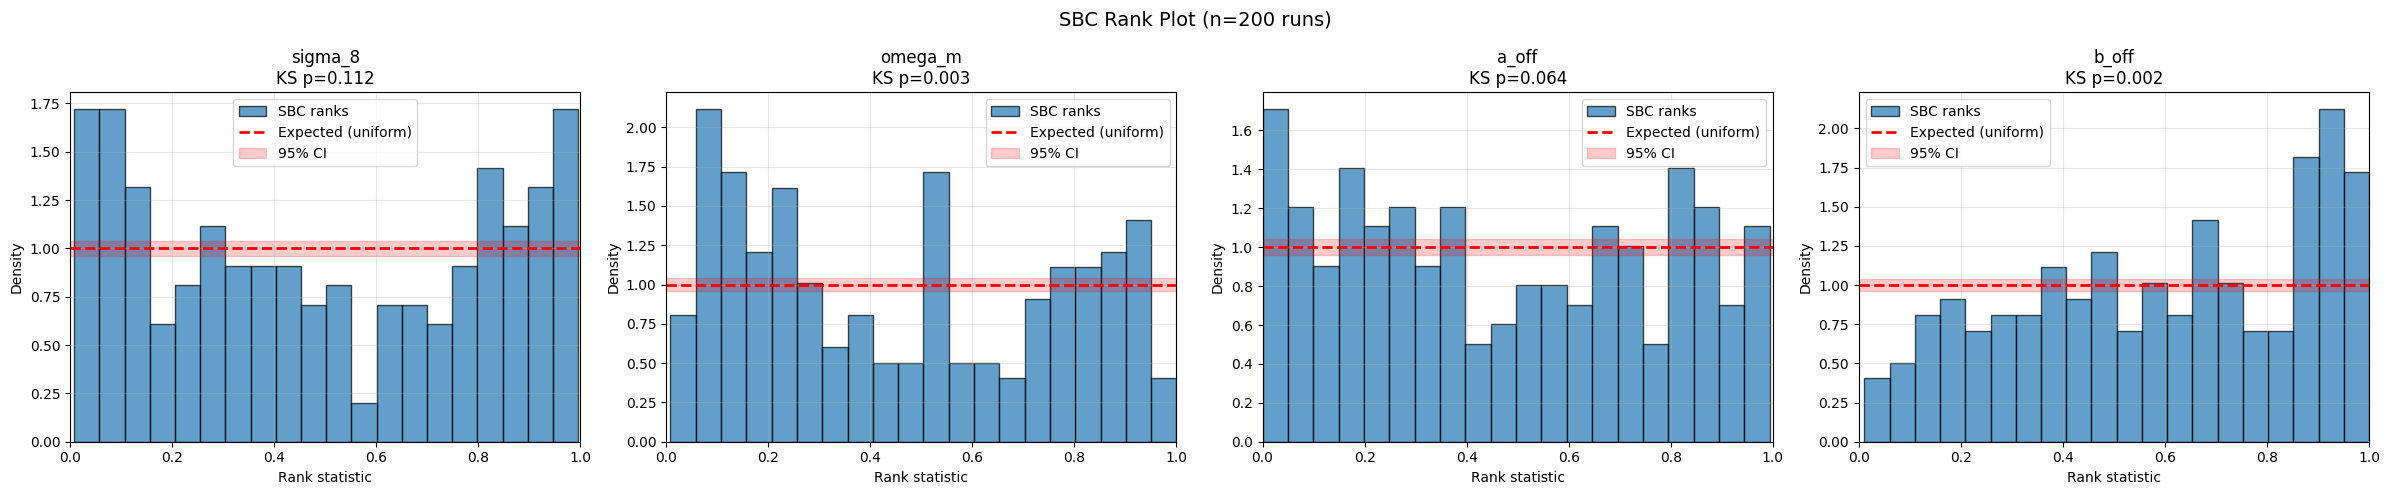


[2/6] Testing coverage...

COVERAGE TEST
Testing coverage on 50 observations...


Coverage:   0%|                                          | 0/50 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Coverage:   6%|██                                | 3/50 [00:00<00:01, 23.52it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Coverage:  12%|████                              | 6/50 [00:00<00:01, 26.53it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Coverage:  18%|██████                            | 9/50 [00:00<00:01, 27.36it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Coverage:  24%|███████▉                         | 12/50 [00:00<00:01, 27.30it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Coverage:  30%|█████████▉                       | 15/50 [00:00<00:01, 26.56it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Coverage:  36%|███████████▉                     | 18/50 [00:00<00:01, 26.82it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Coverage:  44%|██████████████▌                  | 22/50 [00:00<00:00, 28.31it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Coverage:  52%|█████████████████▏               | 26/50 [00:00<00:00, 29.49it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Coverage:  60%|███████████████████▊             | 30/50 [00:01<00:00, 30.15it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Coverage:  68%|██████████████████████▍          | 34/50 [00:01<00:00, 31.37it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Coverage:  76%|█████████████████████████        | 38/50 [00:01<00:00, 30.66it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Coverage:  84%|███████████████████████████▋     | 42/50 [00:01<00:00, 27.03it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Coverage:  92%|██████████████████████████████▎  | 46/50 [00:01<00:00, 28.14it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Coverage: 100%|█████████████████████████████████| 50/50 [00:01<00:00, 28.69it/s]



✓ Coverage test complete:
  68% coverage: 22.0% (target: 68%)
  95% coverage: 92.0% (target: 95%)
  RMSE: 0.4446
  Bias by parameter:
    sigma_8: 0.1808
    omega_m: 0.1267
    a_off: 0.5757
    b_off: 0.4165

  ⚠️ CALIBRATION ISSUES DETECTED

[3/6] Plotting recovery...

Plotting parameter recovery...


Recovery:   0%|                                          | 0/50 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Recovery:   8%|██▋                               | 4/50 [00:00<00:01, 34.59it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Recovery:  16%|█████▍                            | 8/50 [00:00<00:01, 33.87it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Recovery:  24%|███████▉                         | 12/50 [00:00<00:01, 31.25it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Recovery:  32%|██████████▌                      | 16/50 [00:00<00:01, 28.88it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Recovery:  38%|████████████▌                    | 19/50 [00:00<00:01, 28.72it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Recovery:  44%|██████████████▌                  | 22/50 [00:00<00:00, 28.90it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Recovery:  50%|████████████████▌                | 25/50 [00:00<00:00, 27.80it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Recovery:  58%|███████████████████▏             | 29/50 [00:00<00:00, 28.87it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Recovery:  64%|█████████████████████            | 32/50 [00:01<00:00, 28.29it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Recovery:  70%|███████████████████████          | 35/50 [00:01<00:00, 28.39it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Recovery:  76%|█████████████████████████        | 38/50 [00:01<00:00, 27.46it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Recovery:  82%|███████████████████████████      | 41/50 [00:01<00:00, 26.10it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Recovery:  88%|█████████████████████████████    | 44/50 [00:01<00:00, 26.57it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Recovery:  94%|███████████████████████████████  | 47/50 [00:01<00:00, 27.10it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Recovery: 100%|█████████████████████████████████| 50/50 [00:01<00:00, 28.44it/s]


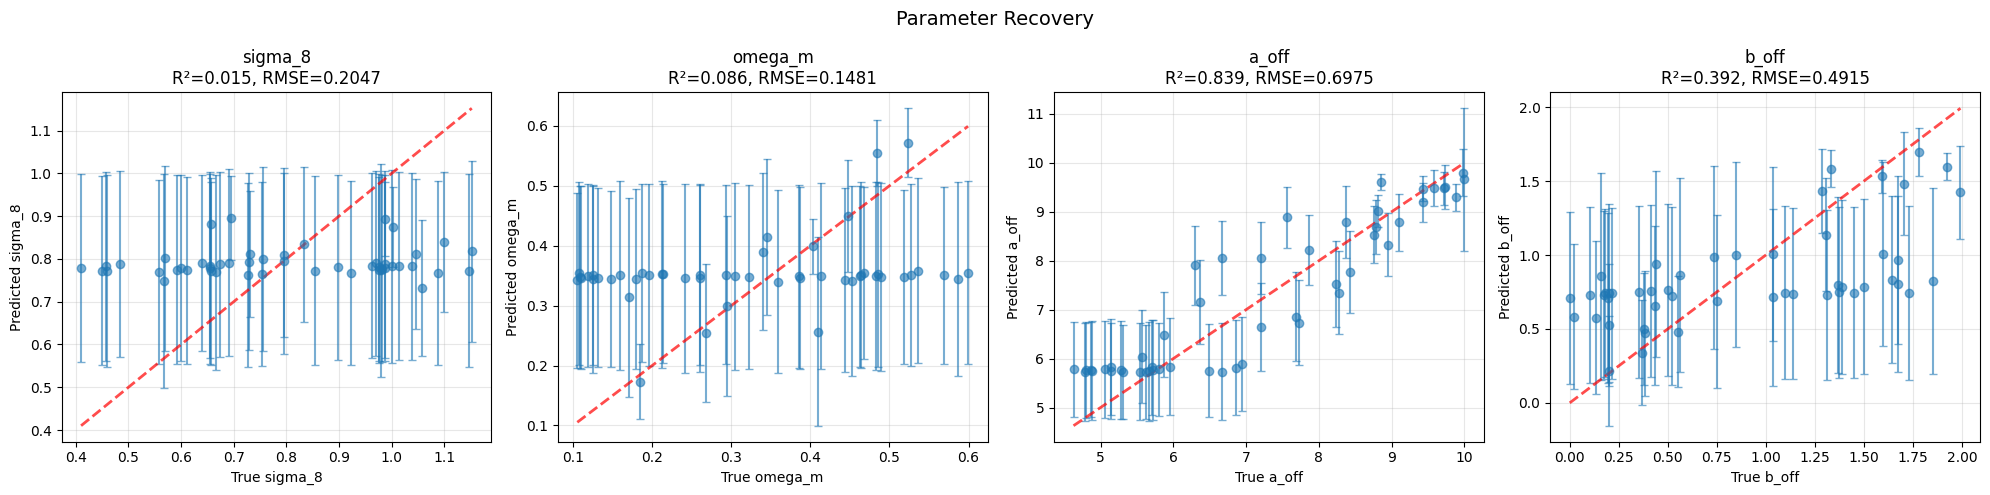


[4/6] Multi-observation testing...

MULTI-OBSERVATION TESTING
Testing on 20 observations...


Testing:   0%|                                           | 0/20 [00:00<?, ?it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Testing:  10%|███▌                               | 2/20 [00:00<00:01, 13.58it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Testing:  20%|███████                            | 4/20 [00:00<00:01, 14.46it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Testing:  30%|██████████▌                        | 6/20 [00:00<00:00, 14.90it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Testing:  40%|██████████████                     | 8/20 [00:00<00:00, 14.67it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Testing:  50%|█████████████████                 | 10/20 [00:00<00:00, 14.61it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Testing:  60%|████████████████████▍             | 12/20 [00:00<00:00, 14.71it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Testing:  70%|███████████████████████▊          | 14/20 [00:00<00:00, 14.99it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Testing:  80%|███████████████████████████▏      | 16/20 [00:01<00:00, 14.89it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Testing:  90%|██████████████████████████████▌   | 18/20 [00:01<00:00, 14.47it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Testing: 100%|██████████████████████████████████| 20/20 [00:01<00:00, 14.68it/s]



✓ Tested 20 observations

Overall performance:
  Mean RMSE: 0.4790
  sigma_8: bias=-0.0280, std=0.2027
  omega_m: bias=0.0039, std=0.1246
  a_off: bias=0.0187, std=0.7693
  b_off: bias=-0.0954, std=0.5091


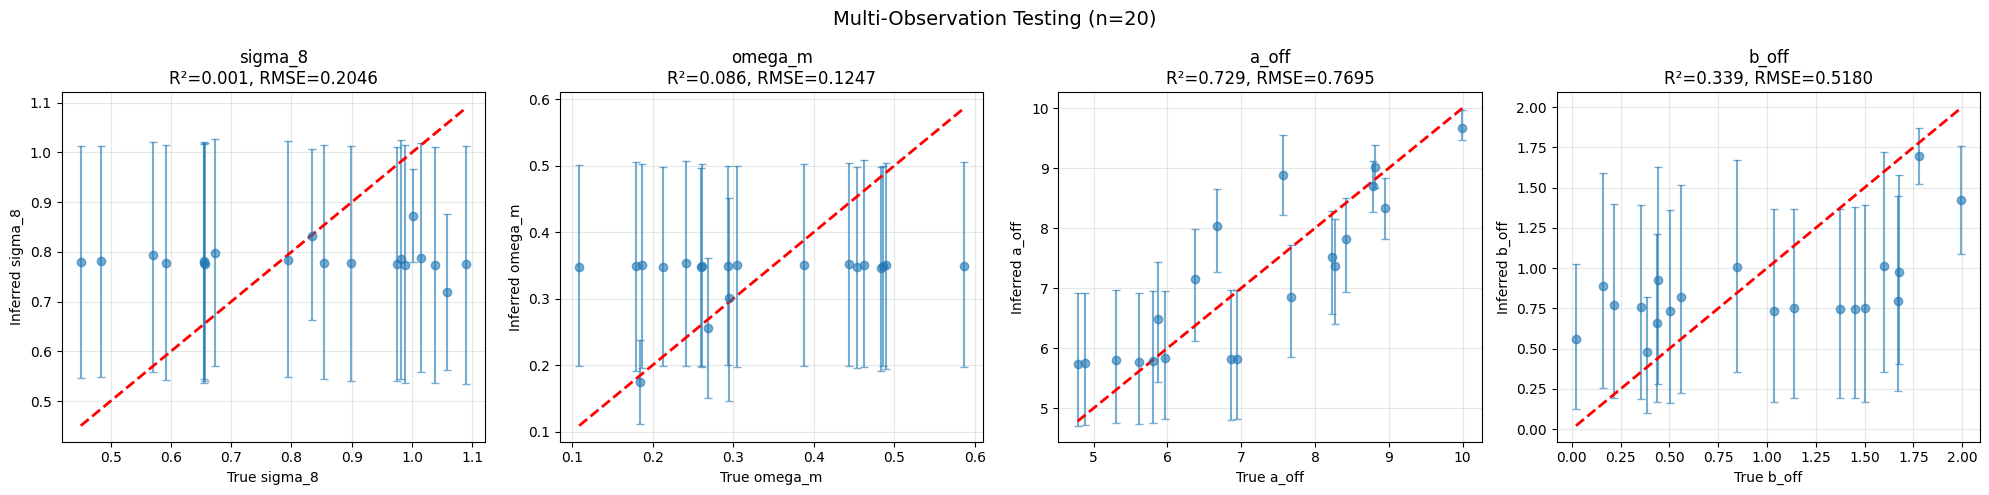


[5/6] CNN feature visualization...

CNN FEATURE VISUALIZATION

Visualizing map 0...

Visualizing map 1...

Visualizing map 2...

Visualizing map 3...

Visualizing map 4...

✓ Feature visualizations saved to: diagnostics_output

[6/6] Generating summary...
FIELD-LEVEL INFERENCE DIAGNOSTIC REPORT

SIMULATION-BASED CALIBRATION (SBC)
----------------------------------------------------------------------
  sigma_8: KS p=0.112 ✅ Pass
  omega_m: KS p=0.003 ⚠️ Fail
  a_off: KS p=0.064 ✅ Pass
  b_off: KS p=0.002 ⚠️ Fail

COVERAGE TEST
----------------------------------------------------------------------
  68% coverage: 22.0%
  95% coverage: 92.0%
  RMSE: 0.4446


✓ ALL DIAGNOSTICS COMPLETE
Results saved to: ./diagnostics_output/


In [6]:
"""
field_level_diagnostics.py

Complete diagnostic suite for field-level inference.
Standalone implementation - does NOT depend on SBIConvergenceTester.

Includes:
1. Validation diagnostics (SBC, coverage tests)
2. Multi-observation testing
3. Architecture comparison
4. CNN feature visualization
"""

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path
from tqdm import tqdm
from scipy import stats
from typing import Dict, List, Tuple, Optional
import warnings


# ============================================================================
# 1. VALIDATION DIAGNOSTICS (SBC & COVERAGE)
# ============================================================================

class FieldLevelValidator:
    """
    Validation diagnostics for field-level inference.
    Standalone implementation for CNN-based SBI.
    """
    
    def __init__(
        self,
        field_inference: FieldLevelInference,
        test_maps: np.ndarray,
        test_params: np.ndarray,
        param_names: List[str],
        output_dir: str
    ):
        """
        Initialize validator.
        
        Args:
            field_inference: Trained FieldLevelInference object
            test_maps: Test intensity maps (N, H, W)
            test_params: True parameters (N, n_params)
            param_names: Names of parameters
            output_dir: Directory for saving results
        """
        self.field_inference = field_inference
        self.test_maps = test_maps
        self.test_params = test_params
        self.param_names = param_names
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(parents=True, exist_ok=True)
        
        self.sbc_ranks = None
        self.coverage_results = None
        
    def run_sbc(self, n_sbc_runs: int = 100, n_posterior_samples: int = 1000):
        """
        Run Simulation-Based Calibration (SBC).
        
        Args:
            n_sbc_runs: Number of SBC runs
            n_posterior_samples: Samples per posterior
            
        Returns:
            SBC ranks (n_runs, n_params)
        """
        print("\n" + "="*70)
        print("SIMULATION-BASED CALIBRATION (SBC)")
        print("="*70)
        
        n_test = min(n_sbc_runs, len(self.test_maps))
        ranks = []
        
        print(f"Running SBC on {n_test} test observations...")
        
        for i in tqdm(range(n_test), desc="SBC"):
            try:
                # Get observation
                test_map = self.test_maps[i]
                true_param = self.test_params[i]
                
                # Sample from posterior
                samples = self.field_inference.infer(
                    observation_map=test_map,
                    n_samples=n_posterior_samples
                )
                
                # Calculate rank
                rank = np.sum(samples < true_param[None, :], axis=0) / n_posterior_samples
                ranks.append(rank)
                
            except Exception as e:
                print(f"\nWarning: SBC failed for observation {i}: {e}")
                continue
        
        self.sbc_ranks = np.array(ranks)
        
        # Analyze
        print(f"\n✓ SBC completed: {len(ranks)} successful runs")
        self._analyze_sbc()
        
        return self.sbc_ranks
    
    def _analyze_sbc(self):
        """Analyze SBC results."""
        print("\n" + "-"*70)
        print("SBC ANALYSIS")
        print("-"*70)
        
        for i, param_name in enumerate(self.param_names):
            param_ranks = self.sbc_ranks[:, i]
            
            # Statistics
            mean_rank = np.mean(param_ranks)
            q1, q3 = np.percentile(param_ranks, [25, 75])
            
            # U-shape detection
            hist, _ = np.histogram(param_ranks, bins=10)
            u_shape = (hist[0] + hist[-1]) / (np.mean(hist[4:6]) + 1e-10)
            
            # KS test
            ks_stat, p_value = stats.kstest(param_ranks, 'uniform')
            
            print(f"\n{param_name}:")
            print(f"  Mean rank: {mean_rank:.3f} (ideal: 0.5)")
            print(f"  Q1-Q3: [{q1:.3f}, {q3:.3f}]")
            print(f"  U-shape score: {u_shape:.2f}")
            print(f"  KS p-value: {p_value:.4f}")
            
            # Interpretation
            if p_value < 0.05:
                if u_shape > 2.0:
                    print(f"  ⚠️ OVERCONFIDENT - CNN overfitting")
                    print(f"     → Increase dropout or reduce capacity")
                elif mean_rank < 0.45:
                    print(f"  ⚠️ UNDERCONFIDENT - Too uncertain")
                elif mean_rank > 0.55:
                    print(f"  ⚠️ BIASED - Systematic offset")
                else:
                    print(f"  ⚠️ MISCALIBRATED")
            else:
                print(f"  ✅ WELL CALIBRATED")
    
    def plot_sbc(self):
        """Plot SBC rank histograms."""
        if self.sbc_ranks is None:
            print("Run SBC first!")
            return
        
        n_params = len(self.param_names)
        fig, axes = plt.subplots(1, n_params, figsize=(6*n_params, 5))
        
        if n_params == 1:
            axes = [axes]
        
        for i, (ax, param_name) in enumerate(zip(axes, self.param_names)):
            ranks = self.sbc_ranks[:, i]
            
            # Histogram
            n_bins = 20 if len(ranks) > 100 else 10
            ax.hist(ranks, bins=n_bins, density=True, alpha=0.7,
                   edgecolor='black', label='SBC ranks')
            
            # Expected uniform
            ax.axhline(1.0, color='red', linestyle='--',
                      label='Expected (uniform)', linewidth=2)
            
            # Confidence band
            n_samples = len(ranks)
            ci_width = 1.96 / np.sqrt(12 * n_samples)
            ax.axhspan(1.0 - ci_width, 1.0 + ci_width,
                      alpha=0.2, color='red', label='95% CI')
            
            # KS test
            _, p_value = stats.kstest(ranks, 'uniform')
            
            ax.set_xlabel('Rank statistic')
            ax.set_ylabel('Density')
            ax.set_title(f'{param_name}\nKS p={p_value:.3f}')
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.set_xlim(0, 1)
        
        plt.suptitle(f'SBC Rank Plot (n={len(self.sbc_ranks)} runs)', fontsize=14)
        plt.tight_layout()
        plt.savefig(self.output_dir / 'sbc_ranks.png', dpi=150, bbox_inches='tight')
        plt.show()
    
    def test_coverage(self, n_test: int = 50):
        """
        Test coverage of confidence intervals.
        
        Args:
            n_test: Number of test observations
        """
        print("\n" + "="*70)
        print("COVERAGE TEST")
        print("="*70)
        
        n_test = min(n_test, len(self.test_maps))
        coverage_68 = 0
        coverage_95 = 0
        errors = []
        
        print(f"Testing coverage on {n_test} observations...")
        
        for i in tqdm(range(n_test), desc="Coverage"):
            try:
                samples = self.field_inference.infer(
                    self.test_maps[i],
                    n_samples=1000
                )
                
                post_mean = np.mean(samples, axis=0)
                errors.append(post_mean - self.test_params[i])
                
                q16, q84 = np.percentile(samples, [16, 84], axis=0)
                q2_5, q97_5 = np.percentile(samples, [2.5, 97.5], axis=0)
                
                if np.all((self.test_params[i] >= q16) & (self.test_params[i] <= q84)):
                    coverage_68 += 1
                if np.all((self.test_params[i] >= q2_5) & (self.test_params[i] <= q97_5)):
                    coverage_95 += 1
                    
            except Exception as e:
                print(f"\nError on sample {i}: {e}")
                continue
        
        errors = np.array(errors)
        
        self.coverage_results = {
            'coverage_68': coverage_68 / n_test,
            'coverage_95': coverage_95 / n_test,
            'rmse': np.sqrt(np.mean(errors**2)),
            'bias': np.mean(np.abs(errors), axis=0)
        }
        
        # Print results
        print(f"\n✓ Coverage test complete:")
        print(f"  68% coverage: {self.coverage_results['coverage_68']:.1%} (target: 68%)")
        print(f"  95% coverage: {self.coverage_results['coverage_95']:.1%} (target: 95%)")
        print(f"  RMSE: {self.coverage_results['rmse']:.4f}")
        print(f"  Bias by parameter:")
        for i, name in enumerate(self.param_names):
            print(f"    {name}: {self.coverage_results['bias'][i]:.4f}")
        
        # Assessment
        if abs(self.coverage_results['coverage_68'] - 0.68) < 0.1 and \
           abs(self.coverage_results['coverage_95'] - 0.95) < 0.1:
            print("\n  ✅ WELL CALIBRATED")
        else:
            print("\n  ⚠️ CALIBRATION ISSUES DETECTED")
    
    def plot_recovery(self, n_test: int = 50):
        """Plot parameter recovery scatter plots."""
        print("\nPlotting parameter recovery...")
        
        n_test = min(n_test, len(self.test_maps))
        n_params = len(self.param_names)
        
        predictions = []
        uncertainties = []
        true_vals = []
        
        for i in tqdm(range(n_test), desc="Recovery"):
            try:
                samples = self.field_inference.infer(self.test_maps[i], n_samples=1000)
                predictions.append(np.mean(samples, axis=0))
                uncertainties.append(np.std(samples, axis=0))
                true_vals.append(self.test_params[i])
            except:
                continue
        
        predictions = np.array(predictions)
        uncertainties = np.array(uncertainties)
        true_vals = np.array(true_vals)
        
        # Plot
        fig, axes = plt.subplots(1, n_params, figsize=(5*n_params, 5))
        if n_params == 1:
            axes = [axes]
        
        for i, (ax, param_name) in enumerate(zip(axes, self.param_names)):
            ax.errorbar(true_vals[:, i], predictions[:, i],
                       yerr=uncertainties[:, i],
                       fmt='o', alpha=0.6, capsize=3)
            
            lims = [true_vals[:, i].min(), true_vals[:, i].max()]
            ax.plot(lims, lims, 'r--', linewidth=2, alpha=0.7)
            
            # R² and RMSE
            r2 = stats.pearsonr(true_vals[:, i], predictions[:, i])[0]**2
            rmse = np.sqrt(np.mean((true_vals[:, i] - predictions[:, i])**2))
            
            ax.set_xlabel(f'True {param_name}')
            ax.set_ylabel(f'Predicted {param_name}')
            ax.set_title(f'{param_name}\nR²={r2:.3f}, RMSE={rmse:.4f}')
            ax.grid(True, alpha=0.3)
        
        plt.suptitle('Parameter Recovery', fontsize=14)
        plt.tight_layout()
        plt.savefig(self.output_dir / 'parameter_recovery.png', dpi=150, bbox_inches='tight')
        plt.show()


# ============================================================================
# 2. MULTI-OBSERVATION TESTING
# ============================================================================

def test_multiple_observations(
    field_inference: FieldLevelInference,
    test_maps: np.ndarray,
    test_params: np.ndarray,
    param_names: List[str],
    output_dir: str,
    n_observations: int = 20
):
    """
    Test field-level inference on multiple observations.
    
    Args:
        field_inference: Trained inference object
        test_maps: Test maps (N, H, W)
        test_params: True parameters (N, n_params)
        param_names: Parameter names
        output_dir: Output directory
        n_observations: Number to test
        
    Returns:
        List of results dictionaries
    """
    print("\n" + "="*70)
    print("MULTI-OBSERVATION TESTING")
    print("="*70)
    
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    n_test = min(n_observations, len(test_maps))
    results = []
    
    print(f"Testing on {n_test} observations...")
    
    for i in tqdm(range(n_test), desc="Testing"):
        try:
            # Infer
            samples = field_inference.infer(test_maps[i], n_samples=5000)
            
            # Statistics
            result = {
                'index': i,
                'true': test_params[i],
                'mean': np.mean(samples, axis=0),
                'std': np.std(samples, axis=0),
                'q16': np.percentile(samples, 16, axis=0),
                'q84': np.percentile(samples, 84, axis=0),
                'samples': samples
            }
            results.append(result)
            
        except Exception as e:
            print(f"\nFailed on observation {i}: {e}")
            continue
    
    # Summary statistics
    print(f"\n✓ Tested {len(results)} observations")
    
    all_errors = np.array([r['mean'] - r['true'] for r in results])
    print(f"\nOverall performance:")
    print(f"  Mean RMSE: {np.sqrt(np.mean(all_errors**2)):.4f}")
    for j, name in enumerate(param_names):
        param_errors = all_errors[:, j]
        print(f"  {name}: bias={np.mean(param_errors):.4f}, std={np.std(param_errors):.4f}")
    
    # Plot
    _plot_multi_obs(results, param_names, output_path)
    
    # Save
    np.savez_compressed(
        output_path / 'multi_observation_results.npz',
        results=results,
        param_names=param_names
    )
    
    return results


def _plot_multi_obs(results: List[Dict], param_names: List[str], output_dir: Path):
    """Plot multi-observation results."""
    n_params = len(param_names)
    fig, axes = plt.subplots(1, n_params, figsize=(5*n_params, 5))
    
    if n_params == 1:
        axes = [axes]
    
    for i, (ax, param_name) in enumerate(zip(axes, param_names)):
        true_vals = [r['true'][i] for r in results]
        means = [r['mean'][i] for r in results]
        q16 = [r['q16'][i] for r in results]
        q84 = [r['q84'][i] for r in results]
        
        yerr = np.array([np.array(means) - np.array(q16),
                         np.array(q84) - np.array(means)])
        
        ax.errorbar(true_vals, means, yerr=yerr, fmt='o', alpha=0.6, capsize=3)
        
        lims = [min(true_vals), max(true_vals)]
        ax.plot(lims, lims, 'r--', linewidth=2)
        
        r2 = stats.pearsonr(true_vals, means)[0]**2
        rmse = np.sqrt(np.mean((np.array(true_vals) - np.array(means))**2))
        
        ax.set_xlabel(f'True {param_name}')
        ax.set_ylabel(f'Inferred {param_name}')
        ax.set_title(f'{param_name}\nR²={r2:.3f}, RMSE={rmse:.4f}')
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Multi-Observation Testing (n={len(results)})', fontsize=14)
    plt.tight_layout()
    plt.savefig(output_dir / 'multi_observation.png', dpi=150, bbox_inches='tight')
    plt.show()


# ============================================================================
# 3. ARCHITECTURE COMPARISON
# ============================================================================

def compare_architectures(
    architectures: Dict[str, FieldLevelInference],
    test_map: np.ndarray,
    true_params: np.ndarray,
    param_names: List[str],
    output_dir: str,
    n_samples: int = 5000
):
    """
    Compare different CNN architectures.
    
    Args:
        architectures: Dict of {name: FieldLevelInference}
        test_map: Single test map
        true_params: True parameters
        param_names: Parameter names
        output_dir: Output directory
        n_samples: Posterior samples
        
    Returns:
        Comparison results dictionary
    """
    print("\n" + "="*70)
    print("ARCHITECTURE COMPARISON")
    print("="*70)
    
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    results = {}
    
    for arch_name, field_inf in architectures.items():
        print(f"\nTesting: {arch_name}")
        
        try:
            samples = field_inf.infer(test_map, n_samples=n_samples)
            
            mean = np.mean(samples, axis=0)
            std = np.std(samples, axis=0)
            rmse = np.sqrt(np.mean((mean - true_params)**2))
            
            results[arch_name] = {
                'samples': samples,
                'mean': mean,
                'std': std,
                'rmse': rmse
            }
            
            print(f"  RMSE: {rmse:.4f}")
            print(f"  Posterior widths: {std}")
            
        except Exception as e:
            print(f"  ❌ Failed: {e}")
            continue
    
    # Plot comparison
    _plot_arch_comparison(results, true_params, param_names, output_path)
    
    # Summary table
    print("\n" + "="*70)
    print("ARCHITECTURE COMPARISON SUMMARY")
    print("="*70)
    print(f"{'Architecture':<20} {'RMSE':<10} {'Avg σ':<10}")
    print("-"*70)
    for name, res in results.items():
        print(f"{name:<20} {res['rmse']:<10.4f} {np.mean(res['std']):<10.4f}")
    
    return results


def _plot_arch_comparison(
    results: Dict,
    true_params: np.ndarray,
    param_names: List[str],
    output_dir: Path
):
    """Plot architecture comparison."""
    n_params = len(param_names)
    n_archs = len(results)
    
    fig, axes = plt.subplots(1, n_params, figsize=(5*n_params, 5))
    if n_params == 1:
        axes = [axes]
    
    colors = plt.cm.tab10(np.linspace(0, 1, n_archs))
    
    for i, (ax, param_name) in enumerate(zip(axes, param_names)):
        for (arch_name, res), color in zip(results.items(), colors):
            samples = res['samples'][:, i]
            ax.hist(samples, bins=50, alpha=0.4, density=True,
                   label=f'{arch_name} (σ={res["std"][i]:.3f})',
                   color=color)
        
        ax.axvline(true_params[i], color='red', linestyle='--',
                  linewidth=2, label='True')
        
        ax.set_xlabel(param_name)
        ax.set_ylabel('Density')
        ax.set_title(f'Posterior: {param_name}')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Architecture Comparison', fontsize=14)
    plt.tight_layout()
    plt.savefig(output_dir / 'architecture_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()


# ============================================================================
# 4. CNN FEATURE VISUALIZATION
# ============================================================================

def visualize_cnn_features(
    field_inference: FieldLevelInference,
    test_maps: np.ndarray,
    test_params: np.ndarray,
    param_names: List[str],
    output_dir: str,
    n_samples: int = 5
):
    """
    Visualize CNN learned features using Grad-CAM.
    
    Args:
        field_inference: Trained inference
        test_maps: Test maps
        test_params: True parameters
        param_names: Parameter names
        output_dir: Output directory
        n_samples: Number of maps to visualize
    """
    print("\n" + "="*70)
    print("CNN FEATURE VISUALIZATION")
    print("="*70)
    
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    embedding_net = field_inference.embedding_net
    embedding_net.eval()
    device = field_inference.device
    
    n_vis = min(n_samples, len(test_maps))
    
    for i in range(n_vis):
        print(f"\nVisualizing map {i}...")
        
        test_map = test_maps[i]
        true_param = test_params[i]
        
        # Grad-CAM
        saliency_map = _compute_gradcam(embedding_net, test_map, device)
        
        # Plot
        fig = plt.figure(figsize=(15, 5))
        gs = gridspec.GridSpec(1, 3, figure=fig)
        
        # Original map
        ax1 = fig.add_subplot(gs[0])
        im1 = ax1.imshow(test_map, cmap='viridis', origin='lower')
        ax1.set_title('Original Map')
        ax1.axis('off')
        plt.colorbar(im1, ax=ax1, fraction=0.046)
        
        # Saliency map
        ax2 = fig.add_subplot(gs[1])
        im2 = ax2.imshow(saliency_map, cmap='hot', origin='lower')
        ax2.set_title('Saliency (Grad-CAM)')
        ax2.axis('off')
        plt.colorbar(im2, ax=ax2, fraction=0.046)
        
        # Overlay
        ax3 = fig.add_subplot(gs[2])
        ax3.imshow(test_map, cmap='gray', origin='lower', alpha=0.6)
        ax3.imshow(saliency_map, cmap='hot', origin='lower', alpha=0.4)
        ax3.set_title('Overlay')
        ax3.axis('off')
        
        # Add parameter info
        param_str = ', '.join([f'{n}={v:.3f}' for n, v in zip(param_names, true_param)])
        plt.suptitle(f'Map {i}: {param_str}', fontsize=12)
        
        plt.tight_layout()
        plt.savefig(output_path / f'feature_viz_map_{i}.png', dpi=150, bbox_inches='tight')
        plt.close()
    
    print(f"\n✓ Feature visualizations saved to: {output_path}")


def _compute_gradcam(model: nn.Module, input_map: np.ndarray, device: str) -> np.ndarray:
    """
    Compute Grad-CAM saliency map.
    
    Args:
        model: CNN embedding network
        input_map: Input intensity map
        device: Device
        
    Returns:
        Saliency map (H, W)
    """
    # Prepare input
    x = torch.from_numpy(input_map[np.newaxis, np.newaxis, :, :]).float().to(device)
    x.requires_grad = True
    
    # Hook to capture activations
    activations = []
    gradients = []
    
    def forward_hook(module, input, output):
        activations.append(output)
    
    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])
    
    # Register hooks on last conv layer
    target_layer = None
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            target_layer = module
    
    if target_layer is None:
        # Fallback: return simple gradient
        output = model(x)
        output.sum().backward()
        return np.abs(x.grad.squeeze().cpu().numpy())
    
    handle_forward = target_layer.register_forward_hook(forward_hook)
    handle_backward = target_layer.register_full_backward_hook(backward_hook)
    
    # Forward pass
    output = model(x)
    
    # Backward pass
    model.zero_grad()
    output.sum().backward()
    
    # Remove hooks
    handle_forward.remove()
    handle_backward.remove()
    
    # Compute Grad-CAM
    if len(activations) > 0 and len(gradients) > 0:
        act = activations[0]
        grad = gradients[0]
        
        # Global average pooling of gradients
        weights = torch.mean(grad, dim=(2, 3), keepdim=True)
        
        # Weighted combination
        cam = torch.sum(weights * act, dim=1, keepdim=True)
        cam = torch.relu(cam)
        
        # Resize to input size
        cam = torch.nn.functional.interpolate(
            cam,
            size=input_map.shape,
            mode='bilinear',
            align_corners=False
        )
        
        cam = cam.squeeze().cpu().detach().numpy()
        
        # Normalize
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    else:
        # Fallback
        cam = np.abs(x.grad.squeeze().cpu().numpy())
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    
    return cam


# ============================================================================
# MAIN DIAGNOSTIC RUNNER
# ============================================================================

def run_all_diagnostics(
    field_inference: FieldLevelInference,
    test_maps: np.ndarray,
    test_params: np.ndarray,
    param_names: List[str],
    output_dir: str
):
    """
    Run all diagnostic tests.
    
    Args:
        field_inference: Trained inference object
        test_maps: Test maps
        test_params: True parameters
        param_names: Parameter names
        output_dir: Output directory
    """
    print("\n" + "="*80)
    print("RUNNING COMPLETE DIAGNOSTIC SUITE")
    print("="*80)
    
    # Initialize validator
    validator = FieldLevelValidator(
        field_inference=field_inference,
        test_maps=test_maps,
        test_params=test_params,
        param_names=param_names,
        output_dir=output_dir
    )
    
    # 1. SBC
    print("\n[1/6] Running SBC...")
    validator.run_sbc(n_sbc_runs=200, n_posterior_samples=1000)
    validator.plot_sbc()
    
    # 2. Coverage
    print("\n[2/6] Testing coverage...")
    validator.test_coverage(n_test=50)
    
    # 3. Recovery plots
    print("\n[3/6] Plotting recovery...")
    validator.plot_recovery(n_test=50)
    
    # 4. Multi-observation
    print("\n[4/6] Multi-observation testing...")
    test_multiple_observations(
        field_inference=field_inference,
        test_maps=test_maps,
        test_params=test_params,
        param_names=param_names,
        output_dir=output_dir,
        n_observations=20
    )
    
    # 5. Feature visualization
    print("\n[5/6] CNN feature visualization...")
    visualize_cnn_features(
        field_inference=field_inference,
        test_maps=test_maps,
        test_params=test_params,
        param_names=param_names,
        output_dir=output_dir,
        n_samples=5
    )
    
    # 6. Summary report
    print("\n[6/6] Generating summary...")
    _generate_summary_report(validator, output_dir)
    
    print("\n" + "="*80)
    print("✓ ALL DIAGNOSTICS COMPLETE")
    print(f"Results saved to: {output_dir}")
    print("="*80)


def _generate_summary_report(validator: FieldLevelValidator, output_dir: str):
    """Generate text summary report."""
    output_path = Path(output_dir)
    
    report = []
    report.append("="*70)
    report.append("FIELD-LEVEL INFERENCE DIAGNOSTIC REPORT")
    report.append("="*70)
    report.append("")
    
    # SBC summary
    if validator.sbc_ranks is not None:
        report.append("SIMULATION-BASED CALIBRATION (SBC)")
        report.append("-"*70)
        for i, param in enumerate(validator.param_names):
            ranks = validator.sbc_ranks[:, i]
            _, p_val = stats.kstest(ranks, 'uniform')
            status = "✅ Pass" if p_val > 0.05 else "⚠️ Fail"
            report.append(f"  {param}: KS p={p_val:.3f} {status}")
        report.append("")
    
    # Coverage summary
    if validator.coverage_results is not None:
        report.append("COVERAGE TEST")
        report.append("-"*70)
        cov = validator.coverage_results
        report.append(f"  68% coverage: {cov['coverage_68']:.1%}")
        report.append(f"  95% coverage: {cov['coverage_95']:.1%}")
        report.append(f"  RMSE: {cov['rmse']:.4f}")
        report.append("")
    
    # Save report
    report_file = output_path / "diagnostic_report.txt"
    with open(report_file, 'w') as f:
        f.write('\n'.join(report))
    
    # Print to console
    print("\n".join(report))


# ============================================================================
# EXAMPLE USAGE
# ============================================================================

if __name__ == "__main__":
    print("Field-level diagnostics module loaded successfully!")
    print("\nExample usage:")

    
    
    # After training field-level inference:
    run_all_diagnostics(
        field_inference=field_inference,
        test_maps=test_maps,
        test_params=test_params,
        param_names=['sigma_8', 'omega_m', 'a_off', 'b_off'],
        output_dir='./diagnostics_output/'
    )
    



COMPREHENSIVE FIELD-LEVEL INFERENCE DIAGNOSIS

Your symptoms:
  - 68% coverage: 4% (should be 68%) ❌
  - Huge biases (log_noise: 2.3) ❌
  - RMSE: 1.23 ❌

Running diagnostics to find root cause...

DIAGNOSTIC 1: CNN Feature Quality


Extracting embeddings: 100%|█████████████████| 100/100 [00:00<00:00, 123.69it/s]



Embedding dimensionality: 128

Correlation of embeddings with parameters:
----------------------------------------------------------------------
  sigma_8: max |r| = 0.182  ⚠️ WEAK - CNN barely learning this parameter
  omega_m: max |r| = 0.242  ⚠️ WEAK - CNN barely learning this parameter
  a_off: max |r| = 0.519  ✅ Good correlation
  b_off: max |r| = 0.353  → Moderate - Could be better


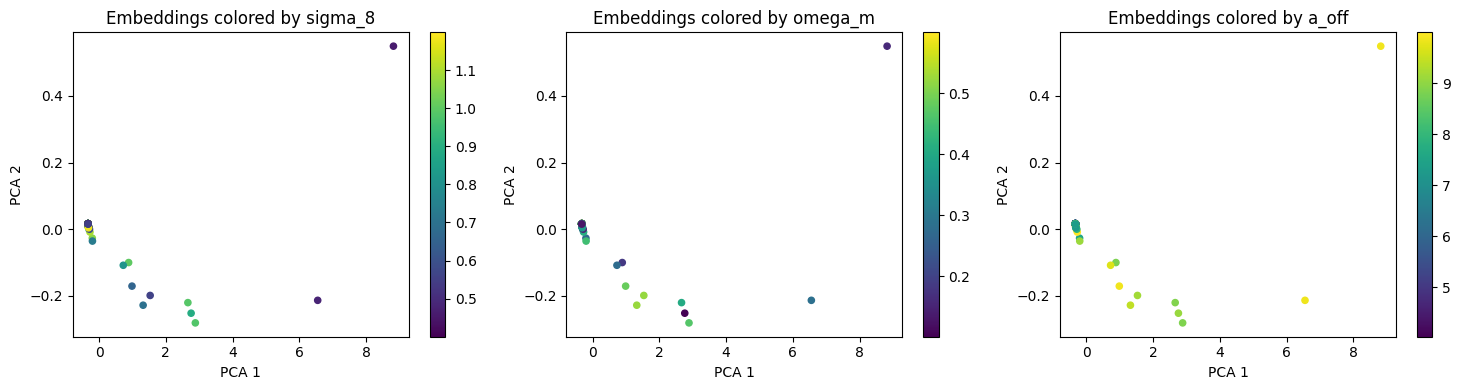


💡 If correlations are all <0.3, the CNN architecture is wrong!

DIAGNOSTIC 2: Preprocessing Quality

Preprocessing method: robust

Preprocessed map statistics:
  Min: -4.8476
  Max: 1850934528.0000
  Mean: 888854.9375
  Std: 10120826.0000

Per-map variance:
  Min: 1.0443
  Max: 38148685502087168.0000
  Mean: 73888662814720.0000


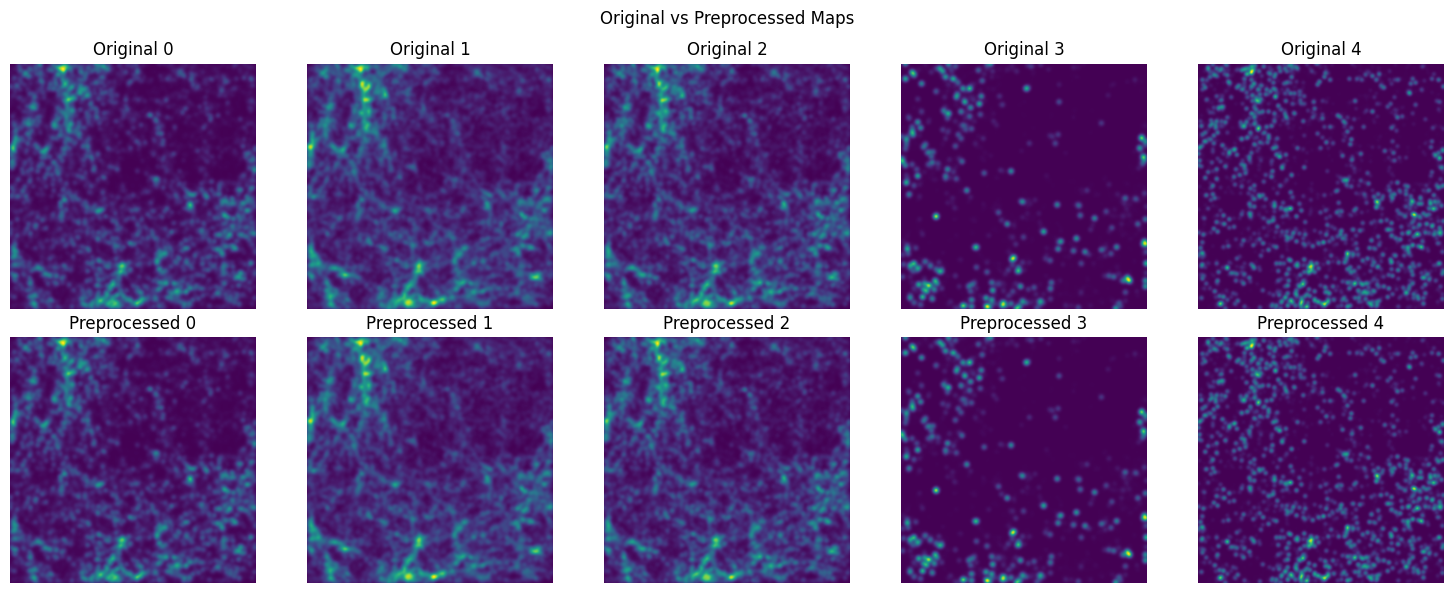


DIAGNOSTIC 3: Train/Test Distribution Match

Parameter distributions:

sigma_8:
  Train: [0.400, 1.200]
  Test:  [0.400, 1.199]
  KS test p-value: 0.4224  ✅ Similar distributions

omega_m:
  Train: [0.100, 0.600]
  Test:  [0.101, 0.600]
  KS test p-value: 0.8836  ✅ Similar distributions

a_off:
  Train: [4.001, 9.999]
  Test:  [4.015, 9.998]
  KS test p-value: 0.7394  ✅ Similar distributions

b_off:
  Train: [0.001, 2.000]
  Test:  [0.000, 1.995]
  KS test p-value: 0.7125  ✅ Similar distributions


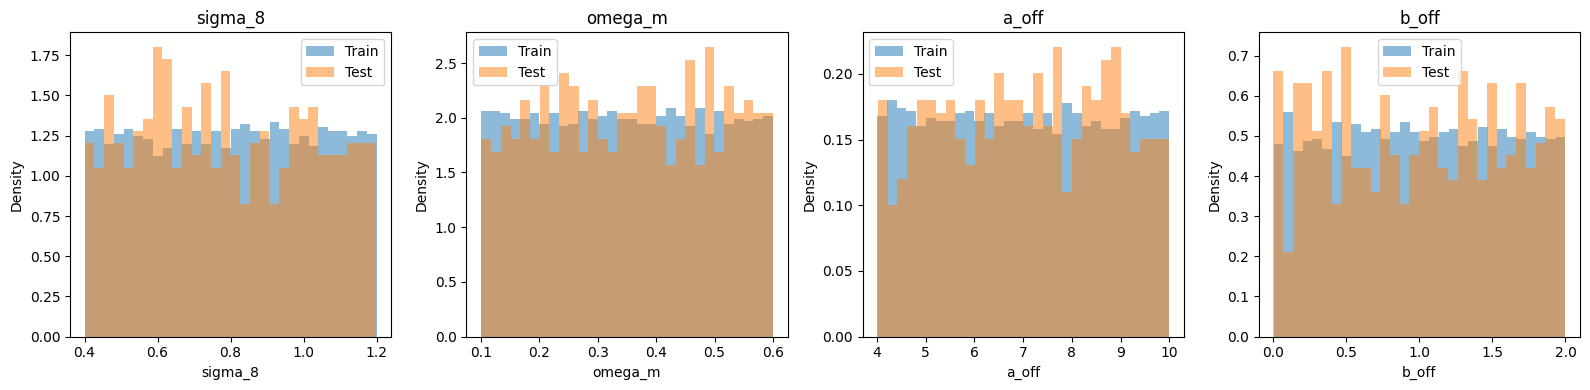


DIAGNOSTIC 4: CNN Sanity Check

Creating synthetic data with simple pattern...

Synthetic signal regression:
  Train R²: -0.000
  Test R²: -0.026
  ❌ CNN CAN'T LEARN EVEN SIMPLE PATTERNS!
     → Architecture is broken or embeddings are random

DIAGNOSTIC 5: Posterior Sample Quality

Test observation 0:


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

  True parameters: [0.79471727 0.24113525 8.4215637  0.56022471]
  Posterior means: [0.7808528  0.3547382  7.8186216  0.84541243]
  Posterior stds:  [0.21796854 0.15444323 0.8256318  0.63776946]
  Errors:          [-0.01386448  0.11360296 -0.60294207  0.28518772]

Test observation 1:


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

  True parameters: [0.85360952 0.29307373 6.94646628 0.21788891]
  Posterior means: [0.7806797 0.3499879 5.87517   0.7631115]
  Posterior stds:  [0.21897538 0.1479504  0.97187376 0.57339126]
  Errors:          [-0.07292982  0.05691416 -1.07129605  0.54522256]

Test observation 2:


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

  True parameters: [0.83355419 0.29461783 9.99791228 0.38504028]
  Posterior means: [0.83793175 0.30561113 9.701269   0.46894884]
  Posterior stds:  [0.17859538 0.1487917  0.4928082  0.4147922 ]
  Errors:          [ 0.00437756  0.0109933  -0.29664313  0.08390857]

Test observation 3:


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

  True parameters: [0.45045328 0.21243762 5.96045195 1.44889948]
  Posterior means: [0.7805133  0.34473944 5.8356376  0.74971175]
  Posterior stds:  [0.21301854 0.15345316 0.9460856  0.58970624]
  Errors:          [ 0.33006     0.13230182 -0.12481438 -0.69918773]

Test observation 4:


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

  True parameters: [0.9753132  0.4529994  5.30459624 1.50239811]
  Posterior means: [0.7752696  0.35615438 5.801814   0.7440238 ]
  Posterior stds:  [0.21823664 0.1456801  0.9671566  0.5661271 ]
  Errors:          [-0.20004358 -0.09684502  0.49721784 -0.75837431]

DIAGNOSIS COMPLETE

Most likely causes (check diagnostic outputs above):
  1. ❌ CNN not learning meaningful features (Diagnostic 1)
  2. ❌ Preprocessing destroying information (Diagnostic 2)
  3. ❌ Train/test mismatch (Diagnostic 3)
  4. ❌ Architecture bug (Diagnostic 4)
  5. ❌ NPE training failed (Diagnostic 5)


In [7]:
"""
Debug script to diagnose why field-level inference is failing catastrophically.

Your symptoms:
- 68% coverage: 4% (should be 68%) ← MAJOR PROBLEM
- 95% coverage: 90% (close to 95%) ← This is OK
- Huge biases (log_noise_level bias = 2.3!) ← MAJOR PROBLEM
- RMSE = 1.23 ← Very large

This means: Posteriors are WAY too narrow AND biased.
"""

import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm


# ============================================================================
# DIAGNOSTIC 1: Check if CNN is learning anything meaningful
# ============================================================================

def diagnose_cnn_learning(field_inference, test_maps, test_params, param_names):
    """
    Check if CNN embeddings correlate with true parameters.
    If not, CNN isn't learning useful features.
    """
    print("\n" + "="*70)
    print("DIAGNOSTIC 1: CNN Feature Quality")
    print("="*70)
    
    embedding_net = field_inference.embedding_net
    embedding_net.eval()
    device = field_inference.device
    
    # Extract embeddings for test maps
    embeddings = []
    for i in tqdm(range(min(100, len(test_maps))), desc="Extracting embeddings"):
        map_tensor = torch.from_numpy(
            test_maps[i][np.newaxis, np.newaxis, :, :]
        ).float().to(device)
        
        with torch.no_grad():
            emb = embedding_net(map_tensor).cpu().numpy().flatten()
            embeddings.append(emb)
    
    embeddings = np.array(embeddings)
    params_subset = test_params[:len(embeddings)]
    
    # Check correlation between embeddings and parameters
    from scipy.stats import pearsonr
    
    print(f"\nEmbedding dimensionality: {embeddings.shape[1]}")
    print(f"\nCorrelation of embeddings with parameters:")
    print("-"*70)
    
    for i, param_name in enumerate(param_names):
        # Find best correlating embedding dimension
        correlations = []
        for j in range(embeddings.shape[1]):
            r, _ = pearsonr(embeddings[:, j], params_subset[:, i])
            correlations.append(abs(r))
        
        max_corr = max(correlations)
        print(f"  {param_name}: max |r| = {max_corr:.3f}", end="")
        
        if max_corr < 0.1:
            print("  ❌ NO CORRELATION - CNN not learning this parameter!")
        elif max_corr < 0.3:
            print("  ⚠️ WEAK - CNN barely learning this parameter")
        elif max_corr < 0.5:
            print("  → Moderate - Could be better")
        else:
            print("  ✅ Good correlation")
    
    # Visualize embeddings via PCA
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    emb_2d = pca.fit_transform(embeddings)
    
    fig, axes = plt.subplots(1, min(3, len(param_names)), figsize=(15, 4))
    if len(param_names) == 1:
        axes = [axes]
    
    for i in range(min(3, len(param_names))):
        ax = axes[i] if len(axes) > 1 else axes
        scatter = ax.scatter(emb_2d[:, 0], emb_2d[:, 1], 
                            c=params_subset[:, i], cmap='viridis', s=20)
        plt.colorbar(scatter, ax=ax)
        ax.set_xlabel('PCA 1')
        ax.set_ylabel('PCA 2')
        ax.set_title(f'Embeddings colored by {param_names[i]}')
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 If correlations are all <0.3, the CNN architecture is wrong!")


# ============================================================================
# DIAGNOSTIC 2: Check preprocessing issues
# ============================================================================

def diagnose_preprocessing(train_dataset, test_maps, test_params):
    """
    Check if preprocessing is destroying information.
    """
    print("\n" + "="*70)
    print("DIAGNOSTIC 2: Preprocessing Quality")
    print("="*70)
    
    # Check preprocessed map statistics
    print(f"\nPreprocessing method: {train_dataset.preprocessing}")
    print(f"\nPreprocessed map statistics:")
    print(f"  Min: {train_dataset.maps_processed.min():.4f}")
    print(f"  Max: {train_dataset.maps_processed.max():.4f}")
    print(f"  Mean: {train_dataset.maps_processed.mean():.4f}")
    print(f"  Std: {train_dataset.maps_processed.std():.4f}")
    
    # Check if all maps look the same after preprocessing
    variances = np.var(train_dataset.maps_processed, axis=(1, 2))
    print(f"\nPer-map variance:")
    print(f"  Min: {variances.min():.4f}")
    print(f"  Max: {variances.max():.4f}")
    print(f"  Mean: {variances.mean():.4f}")
    
    if variances.std() / variances.mean() < 0.1:
        print("  ❌ WARNING: All maps have similar variance!")
        print("     Preprocessing may be over-normalizing!")
    
    # Visualize a few preprocessed maps
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i in range(5):
        # Original
        axes[0, i].imshow(test_maps[i], cmap='viridis', origin='lower')
        axes[0, i].set_title(f'Original {i}')
        axes[0, i].axis('off')
        
        # Preprocessed
        preprocessed = train_dataset._preprocess_maps(test_maps[i:i+1])[0]
        axes[1, i].imshow(preprocessed, cmap='viridis', origin='lower')
        axes[1, i].set_title(f'Preprocessed {i}')
        axes[1, i].axis('off')
    
    plt.suptitle('Original vs Preprocessed Maps')
    plt.tight_layout()
    plt.show()


# ============================================================================
# DIAGNOSTIC 3: Check if training data is representative
# ============================================================================

def diagnose_data_distribution(train_params, test_params, param_names):
    """
    Check if train/test distributions match.
    """
    print("\n" + "="*70)
    print("DIAGNOSTIC 3: Train/Test Distribution Match")
    print("="*70)
    
    fig, axes = plt.subplots(1, len(param_names), figsize=(4*len(param_names), 4))
    if len(param_names) == 1:
        axes = [axes]
    
    print("\nParameter distributions:")
    for i, (ax, param_name) in enumerate(zip(axes, param_names)):
        ax.hist(train_params[:, i], bins=30, alpha=0.5, label='Train', density=True)
        ax.hist(test_params[:, i], bins=30, alpha=0.5, label='Test', density=True)
        ax.set_xlabel(param_name)
        ax.set_ylabel('Density')
        ax.legend()
        ax.set_title(param_name)
        
        # KS test
        from scipy.stats import ks_2samp
        stat, p_value = ks_2samp(train_params[:, i], test_params[:, i])
        
        print(f"\n{param_name}:")
        print(f"  Train: [{train_params[:, i].min():.3f}, {train_params[:, i].max():.3f}]")
        print(f"  Test:  [{test_params[:, i].min():.3f}, {test_params[:, i].max():.3f}]")
        print(f"  KS test p-value: {p_value:.4f}", end="")
        
        if p_value < 0.05:
            print("  ❌ DIFFERENT DISTRIBUTIONS!")
        else:
            print("  ✅ Similar distributions")
    
    plt.tight_layout()
    plt.show()


# ============================================================================
# DIAGNOSTIC 4: Sanity check - can CNN predict from a simple signal?
# ============================================================================

def sanity_check_cnn(embedding_net, device):
    """
    Test if CNN can learn from a simple synthetic signal.
    If it can't, there's a bug in the architecture.
    """
    print("\n" + "="*70)
    print("DIAGNOSTIC 4: CNN Sanity Check")
    print("="*70)
    
    # Create synthetic data with clear signal
    print("\nCreating synthetic data with simple pattern...")
    n_samples = 500
    
    synthetic_maps = []
    synthetic_params = []
    
    for i in range(n_samples):
        # Simple pattern: intensity increases with parameter
        param = np.random.uniform(0, 1)
        
        # Create map with signal
        x, y = np.meshgrid(np.linspace(0, 1, 256), np.linspace(0, 1, 256))
        map_data = param * (x + y) + np.random.normal(0, 0.1, (256, 256))
        
        synthetic_maps.append(map_data)
        synthetic_params.append([param])
    
    synthetic_maps = np.array(synthetic_maps)
    synthetic_params = np.array(synthetic_params)
    
    # Try to fit a simple regression
    from sklearn.linear_model import Ridge
    
    # Extract embeddings
    embeddings = []
    embedding_net.eval()
    
    for i in range(n_samples):
        map_tensor = torch.from_numpy(
            synthetic_maps[i:i+1, np.newaxis, :, :]
        ).float().to(device)
        
        with torch.no_grad():
            emb = embedding_net(map_tensor).cpu().numpy().flatten()
            embeddings.append(emb)
    
    embeddings = np.array(embeddings)
    
    # Train simple regressor
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, synthetic_params, test_size=0.2, random_state=42
    )
    
    reg = Ridge(alpha=1.0)
    reg.fit(X_train, y_train)
    
    train_r2 = reg.score(X_train, y_train)
    test_r2 = reg.score(X_test, y_test)
    
    print(f"\nSynthetic signal regression:")
    print(f"  Train R²: {train_r2:.3f}")
    print(f"  Test R²: {test_r2:.3f}")
    
    if test_r2 < 0.3:
        print("  ❌ CNN CAN'T LEARN EVEN SIMPLE PATTERNS!")
        print("     → Architecture is broken or embeddings are random")
    elif test_r2 < 0.6:
        print("  ⚠️ CNN learns weakly")
    else:
        print("  ✅ CNN can learn patterns")


# ============================================================================
# DIAGNOSTIC 5: Check posterior samples
# ============================================================================

def diagnose_posterior_samples(field_inference, test_maps, test_params, param_names):
    """
    Check if posterior samples are reasonable.
    """
    print("\n" + "="*70)
    print("DIAGNOSTIC 5: Posterior Sample Quality")
    print("="*70)
    
    # Get samples for a few test observations
    n_test = min(5, len(test_maps))
    
    for i in range(n_test):
        print(f"\nTest observation {i}:")
        
        try:
            samples = field_inference.infer(test_maps[i], n_samples=1000)
            
            print(f"  True parameters: {test_params[i]}")
            print(f"  Posterior means: {np.mean(samples, axis=0)}")
            print(f"  Posterior stds:  {np.std(samples, axis=0)}")
            print(f"  Errors:          {np.mean(samples, axis=0) - test_params[i]}")
            
            # Check if posteriors are degenerate
            if np.any(np.std(samples, axis=0) < 1e-3):
                print("  ❌ DEGENERATE POSTERIOR - no uncertainty!")
            
            # Check if samples are all the same
            if np.std(samples) < 1e-6:
                print("  ❌ ALL SAMPLES IDENTICAL - NPE not trained properly!")
            
        except Exception as e:
            print(f"  ❌ Inference failed: {e}")


# ============================================================================
# MAIN DIAGNOSTIC RUNNER
# ============================================================================

def run_full_diagnosis(
    field_inference,
    train_maps,
    train_params,
    test_maps,
    test_params,
    param_names
):
    """
    Run all diagnostics to find the problem.
    """
    print("\n" + "="*80)
    print("COMPREHENSIVE FIELD-LEVEL INFERENCE DIAGNOSIS")
    print("="*80)
    print("\nYour symptoms:")
    print("  - 68% coverage: 4% (should be 68%) ❌")
    print("  - Huge biases (log_noise: 2.3) ❌")
    print("  - RMSE: 1.23 ❌")
    print("\nRunning diagnostics to find root cause...")
    
    # 1. Check CNN learning
    diagnose_cnn_learning(field_inference, test_maps, test_params, param_names)
    
    # 2. Check preprocessing
    if hasattr(field_inference, 'train_dataset'):
        diagnose_preprocessing(
            field_inference.train_dataset, 
            test_maps, 
            test_params
        )
    
    # 3. Check data distributions
    diagnose_data_distribution(train_params, test_params, param_names)
    
    # 4. Sanity check CNN
    sanity_check_cnn(field_inference.embedding_net, field_inference.device)
    
    # 5. Check posterior samples
    diagnose_posterior_samples(field_inference, test_maps, test_params, param_names)
    
    print("\n" + "="*80)
    print("DIAGNOSIS COMPLETE")
    print("="*80)
    print("\nMost likely causes (check diagnostic outputs above):")
    print("  1. ❌ CNN not learning meaningful features (Diagnostic 1)")
    print("  2. ❌ Preprocessing destroying information (Diagnostic 2)")
    print("  3. ❌ Train/test mismatch (Diagnostic 3)")
    print("  4. ❌ Architecture bug (Diagnostic 4)")
    print("  5. ❌ NPE training failed (Diagnostic 5)")


# ============================================================================
# QUICK FIXES
# ============================================================================

def suggest_fixes(diagnostic_results):
    """
    Based on diagnostic results, suggest specific fixes.
    """
    print("\n" + "="*80)
    print("SUGGESTED FIXES")
    print("="*80)
    



# ============================================================================
# USAGE
# ============================================================================

if __name__ == "__main__":

# After training field_inference:
    run_full_diagnosis(
        field_inference=field_inference,
        train_maps=train_maps,
        train_params=train_params,
        test_maps=test_maps,
        test_params=test_params,
        param_names=['sigma_8', 'omega_m', 'a_off', 'b_off']
    )
